In [1]:
# define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
from src.utils.Notebook_imports import *
#from pyforest import *
from src.utils.Tensorflow_helper import choose_gpu_by_id
from tensorflow.keras.utils import plot_model
from tensorflow.python.client import device_lib
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
import cv2
# define GPU id to use
GPU_IDS = '0,1'
GPUS = choose_gpu_by_id(GPU_IDS)
print(GPUS)

# jupyter magic config
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# import helpers
from src.utils.Utils_io import Console_and_file_logger, init_config
from src.visualization.Visualize import show_2D_or_3D
from src.data.Dataset import get_img_msk_files_from_split_dir, load_acdc_files, get_train_data_from_df, get_trainings_files
from src.data.Generators import DataGenerator, get_samples, CycleMotionDataGenerator
from src.utils.KerasCallbacks import get_callbacks
import src.utils.Metrics_own as metr
import src.models.SpatialTransformer as st
from src.models.SpatialTransformer import create_affine_cycle_transformer_model
from src.models.ModelUtils import load_pretrained_model

# path params
ARCHITECTURE = '3D' # 2D
DATASET = 'GCN'  # 'acdc' # or 'gcn'
FOLD = 3 # CV fold 0-3

# Define an experiment name, could have subfolder conventions
EXP_NAME = 'ax_sax/unetwithdownsamplingaugmentation_new_data'

# Uniform path names, separation of concerns
EXPERIMENT = '{}/{}'.format(ARCHITECTURE, EXP_NAME)
timestemp = str(datetime.datetime.now().strftime("%Y-%m-%d_%H_%M"))
#TRAIN_PATH = 'data/raw/{}/{}/train/'.format(DATASET, ARCHITECTURE)
#VAL_PATH = 'data/raw/{}/{}/val/'.format(DATASET, ARCHITECTURE)
#TEST_PATH = 'data/raw/{}/{}/val/'.format(DATASET, ARCHITECTURE)

DATA_PATH = '/mnt/ssd/data/gcn/ax_sax_from_flo/AX_3D/' # for cv
DATA_PATH_AX2SAX = DATA_PATH.replace('AX_3D', 'AX_to_SAX_3D')
DF_PATH = '/mnt/ssd/data/gcn/gcn_05_2020_ax_sax_86/folds.csv'

MODEL_PATH = os.path.join('models', EXPERIMENT, timestemp)
TENSORBOARD_LOG_DIR = os.path.join('reports/tensorboard_logs', EXPERIMENT,timestemp)
CONFIG_PATH = os.path.join('reports/configs/',EXPERIMENT,timestemp)
HISTORY_PATH = os.path.join('reports/history/',EXPERIMENT,timestemp)

# Hyperparameters and experiment definition, to avoid code changes and parameter combinations compareable
DIM = [72, 112, 112] # network input params for spacing of 3, (z,y,x)
DEPTH = 4 # number of down-/upsampling blocks
FILTERS = 16 # initial number of filters, will be doubled after each downsampling block
SPACING = [3,3, 3] # if resample, resample to this spacing, (z,y,x)
M_POOL = [2, 2, 2]# used for downsampling and upsampling
F_SIZE = [3, 3, 3] # conv filter size
IMG_CHANNELS = 1 # Currently our model needs that image channel
MASK_VALUES = [1, 2, 3]  #channel order: Background, RV, MYO, LV
MASK_CLASSES = len(MASK_VALUES) # no of labels
BORDER_MODE = cv2.BORDER_REFLECT_101
IMG_INTERPOLATION = cv2.INTER_LINEAR
MSK_INTERPOLATION = cv2.INTER_NEAREST
AUGMENT = False
SHUFFLE = True
AUGMENT_GRID = False
RESAMPLE = True
SCALER = 'MinMax' # MinMax Standard or Robust

AX_LOSS_WEIGHT = 1.0
WEIGHT_MSE_INPLANE = True
MASK_SMALLER_THAN_THRESHOLD = 0.001

SAX_LOSS_WEIGHT = 1.0
CYCLE_LOSS = True

FOCUS_LOSS_WEIGHT = 1.0
FOCUS_LOSS = True
USE_SAX2AX_PROB = False
MIN_UNET_PROBABILITY = 0.8

# training params
GENERATOR_WORKER = 2 # if not set, use batchsize
SEED = 42 # define a seed for the generator shuffle
BATCHSIZE = 2 # 32, 64, 24, 16, 1 for 3D use: 8
INITIAL_EPOCH = 0 # change this to continue training
EPOCHS = 300 # define a maximum numbers of epochs
EPOCHS_BETWEEN_CHECKPOINTS = 5
MONITOR_FUNCTION = 'val_loss'
MONITOR_MODE = 'min'
SAVE_MODEL_FUNCTION = 'val_loss'
SAVE_MODEL_MODE = 'min'
MODEL_PATIENCE = 20
BN_FIRST = False # decide if BN between Conv and activation or afterwards
BATCH_NORMALISATION = True # apply BN or not
USE_UPSAMPLE = True # otherwise use transpose
PAD = 'same' # padding strategy
KERNEL_INIT = 'he_normal' # conv weight initialisation
OPTIMIZER = 'adam' # Adam, Adagrad, RMSprop, Adadelta,  # https://keras.io/optimizers/
ACTIVATION = 'elu' # tf.keras.layers.LeakyReLU(), relu or any other non linear activation function
LEARNING_RATE = 1e-4 # start with a huge lr to converge fast
DECAY_FACTOR = 0.3 # Define a learning rate decay for the ReduceLROnPlateau callback
MIN_LR = 1e-10 # minimal lr, smaller lr does not improve the model
DROPOUT_min = 0.3 # lower dropout at the shallow layers
DROPOUT_max = 0.5 # higher dropout at the deep layers

metrics = [
    metr.dice_coef_labels,
    metr.dice_coef_myo,
    metr.dice_coef_lv,
    metr.dice_coef_rv
]


LOSS_FUNCTION = metr.bce_dice_loss

Console_and_file_logger(EXPERIMENT, logging.INFO)

# Define a config for param injection,
# save a serialized version, 
# make sure all paths exist
config = init_config(config=locals(), save=True)
print(config)

search for root_dir and set working directory
Working directory set to: /mnt/ssd/git/3d-mri-domain-adaption


2020-12-02 08:59:23,366 INFO -------------------- Start --------------------
2020-12-02 08:59:23,366 INFO Working directory: /mnt/ssd/git/3d-mri-domain-adaption.
2020-12-02 08:59:23,366 INFO Log file: ./logs/3D/ax_sax/unetwithdownsamplingaugmentation_new_data.log
2020-12-02 08:59:23,367 INFO Log level for console: INFO


['/gpu:0', '/gpu:1']
{'GPU_IDS': '0,1', 'GPUS': ['/gpu:0', '/gpu:1'], 'ARCHITECTURE': '3D', 'DATASET': 'GCN', 'FOLD': 3, 'EXP_NAME': 'ax_sax/unetwithdownsamplingaugmentation_new_data', 'EXPERIMENT': '3D/ax_sax/unetwithdownsamplingaugmentation_new_data', 'DATA_PATH': '/mnt/ssd/data/gcn/ax_sax_from_flo/AX_3D/', 'DATA_PATH_AX2SAX': '/mnt/ssd/data/gcn/ax_sax_from_flo/AX_to_SAX_3D/', 'DF_PATH': '/mnt/ssd/data/gcn/gcn_05_2020_ax_sax_86/folds.csv', 'MODEL_PATH': 'models/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-12-02_08_59', 'TENSORBOARD_LOG_DIR': 'reports/tensorboard_logs/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-12-02_08_59', 'CONFIG_PATH': 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-12-02_08_59', 'HISTORY_PATH': 'reports/history/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-12-02_08_59', 'DIM': [72, 112, 112], 'DEPTH': 4, 'FILTERS': 16, 'SPACING': [3, 3, 3], 'M_POOL': [2, 2, 2], 'F_SIZE': [3, 3, 3], 'IMG_CHANNELS': 1, '

# Check Tensorflow setup and available GPUs

In [2]:
from tensorflow.keras.mixed_precision import experimental as mixed_precision
logging.info('Is built with tensorflow: {}'.format(tf.test.is_built_with_cuda()))
logging.info('Visible devices:\n{}'.format(tf.config.list_physical_devices()))
logging.info('Local devices: \n {}'.format(device_lib.list_local_devices()))
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)
logging.info('Compute dtype: %s' % policy.compute_dtype)
logging.info('Variable dtype: %s' % policy.variable_dtype)

2020-12-02 08:59:25,919 INFO Is built with tensorflow: True
2020-12-02 08:59:26,032 INFO Visible devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
2020-12-02 08:59:26,905 INFO Local devices: 
 [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12672193410367736143
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 319085591701795254
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13325506959690823631
physical_device_desc:

# Load trainings and validation files for the choosen fold

In [3]:
# Load AX volumes
x_train_ax, y_train_ax, x_val_ax, y_val_ax =  get_trainings_files(data_path=DATA_PATH,path_to_folds_df=DF_PATH, fold=FOLD)

logging.info('AX x_train files: {}, AX y_train files: {}'.format(len(x_train_ax), len(y_train_ax)))
logging.info('AX x_val files: {}, AX y_val files: {}'.format(len(x_val_ax), len(y_val_ax)))

# load AX2SAX volumes, they should be in the same directory but with a different suffix --> AX_to_SAX_3D
x_train_sax, y_train_sax, x_val_sax, y_val_sax =  get_trainings_files(data_path=DATA_PATH_AX2SAX,path_to_folds_df=DF_PATH, fold=FOLD)
config = init_config(config)

logging.info('x_train files: {}, y_train files: {}'.format(len(x_train_sax), len(y_train_sax)))
logging.info('x_val files: {}, y_val files: {}'.format(len(x_val_sax), len(y_val_sax)))

2020-12-02 08:59:31,042 INFO Found 162 images/masks in /mnt/ssd/data/gcn/ax_sax_from_flo/AX_3D/
2020-12-02 08:59:31,043 INFO Patients train: 65
2020-12-02 08:59:31,049 INFO Selected 122 of 162 files with 65 of 86 patients for training fold 3
2020-12-02 08:59:31,050 INFO AX x_train files: 122, AX y_train files: 122
2020-12-02 08:59:31,050 INFO AX x_val files: 40, AX y_val files: 40
2020-12-02 08:59:31,054 INFO Found 162 images/masks in /mnt/ssd/data/gcn/ax_sax_from_flo/AX_to_SAX_3D/
2020-12-02 08:59:31,054 INFO Patients train: 65
2020-12-02 08:59:31,060 INFO Selected 122 of 162 files with 65 of 86 patients for training fold 3
2020-12-02 08:59:31,061 INFO x_train files: 122, y_train files: 122
2020-12-02 08:59:31,062 INFO x_val files: 40, y_val files: 40


In [4]:
# filter files by name, debugging purpose
#x_val_ax = [x for x in x_val_ax if '4A4PVCYL_2006' in x]
#x_val_sax = [x for x in x_val_sax if '4A4PVCYL_2006' in x]
#y_val_ax = [x for x in y_val_ax if '4A4PVCYL_2006' in x]
print(len(x_val_ax))
print(len(x_val_sax))
print(len(y_val_ax))

40
40
40


In [5]:
# create two generators, one for the training files, one for the validation files
batch_generator = CycleMotionDataGenerator(x_train_ax, x_train_sax, config)
valid_config = config.copy()
valid_config['AUGMENT_GRID'] = False
valid_config['AUGMENT'] = False
valid_generator = CycleMotionDataGenerator(x_val_ax, x_val_sax, valid_config)

2020-12-02 08:59:32,206 INFO Create DataGenerator
2020-12-02 08:59:32,207 INFO Datagenerator created with: 
 shape: [72, 112, 112]
 spacing: [3, 3, 3]
 batchsize: 2
 Scaler: MinMax
 Images: 122 
 Augment_grid: False 
 Thread workers: 2
2020-12-02 08:59:32,208 INFO No augmentation
2020-12-02 08:59:32,208 INFO Create DataGenerator
2020-12-02 08:59:32,208 INFO Datagenerator created with: 
 shape: [72, 112, 112]
 spacing: [3, 3, 3]
 batchsize: 2
 Scaler: MinMax
 Images: 40 
 Augment_grid: False 
 Thread workers: 2
2020-12-02 08:59:32,209 INFO No augmentation


In [6]:
# Select batch generator output
x = ''
y = ''
@interact
def select_batch(batch = (0,len(valid_generator), 1)):
    global x, y, x2, y2
    input_ , output_ = valid_generator.__getitem__(batch)
    x = input_[0]
    y = output_[0]
    x2 = input_[1]
    y2 = output_[1]
    logging.info('input elements: {}'.format(len(input_)))
    logging.info('output elements: {}'.format(len(output_)))
    logging.info(x.shape)
    logging.info(y.shape)
    logging.info(x2.shape)
    logging.info(y2.shape)

interactive(children=(IntSlider(value=10, description='batch', max=20), Output()), _dom_classes=('widget-inter…

In [7]:
@interact
def select_image_in_batch(im = (0,x.shape[0]- 1, 1),slice_by=(1,6)):
    
    # define a different logging level to make the generator steps visible
    logging.getLogger().setLevel(logging.DEBUG)
    temp_dir = 'reports/figures/temp/'
    ensure_dir(temp_dir)

    logging.info('AX: {}'.format(x[im].shape))
    show_2D_or_3D(x[im][...,0][::slice_by])
    plt.savefig(os.path.join(temp_dir,'ax.pdf'))
    plt.show()
    logging.info('AXtoSAX: {}'.format(y[im].shape))
    show_2D_or_3D(y[im][...,0][::slice_by])
    plt.savefig(os.path.join(temp_dir,'ax2sax.pdf'))
    plt.show()
    logging.info('SAX: {}'.format(x2[im].shape))
    show_2D_or_3D(x2[im][...,0][::slice_by])
    plt.savefig(os.path.join(temp_dir,'sax.pdf'))
    plt.show()
    logging.info('SAXtoAX: {}'.format(y2[im].shape))
    show_2D_or_3D(y2[im][...,0][::slice_by])
    plt.savefig(os.path.join(temp_dir,'sax2ax.pdf'))
    plt.show()
    

interactive(children=(IntSlider(value=0, description='im', max=1), IntSlider(value=3, description='slice_by', …

In [8]:
# load a pretrained 2D unet
"""
load past config for model training 
"""
if 'strategy' not in globals():
    # distribute the training with the mirrored data paradigm across multiple gpus if available, if not use gpu 0
    strategy = tf.distribute.MirroredStrategy(devices=config.get('GPUS', ["/gpu:0"]))
    
if 'config_chooser' in locals():
    config_file  = config_chooser.selected
else:
    #config_file = '/mnt/ssd/git/3d-mri-domain-adaption/reports/configs/2D/gcn_and_acdc_excl_ax/config.json' # config for TMI paper
    config_file = '/mnt/ssd/git/cardio/reports/configs/2D/gcn_05_2020_sax_excl_ax_patients/2020-11-20_17_24/config.json' # retrained with downsampling

# load config with all params into global namespace
with open(config_file, encoding='utf-8') as data_file:
    config_temp = json.loads(data_file.read())
config_temp['LOSS_FUNCTION'] = config['LOSS_FUNCTION']
logging.info('Load model from Experiment: {}'.format(config_temp['EXPERIMENT']))

with strategy.scope():
    globals()['unet'] = load_pretrained_model(config_temp, metrics, comp=False)

2020-12-02 08:59:34,871 INFO Load model from Experiment: 2D/gcn_05_2020_sax_excl_ax_patients
2020-12-02 08:59:34,872 INFO load model with keras api
2020-12-02 08:59:37,280 INFO Unable to restore custom object of type _tf_keras_metric currently. Please make sure that the layer implements `get_config`and `from_config` when saving. In addition, please use the `custom_objects` arg when calling `load_model()`.
2020-12-02 08:59:37,282 INFO Keras API failed, use json repr. load model from: models/2D/gcn_05_2020_sax_excl_ax_patients/2020-11-20_17_24/model.json .
2020-12-02 08:59:37,282 INFO loading model description
2020-12-02 08:59:38,142 INFO loading model weights
2020-12-02 08:59:38,359 INFO model models/2D/gcn_05_2020_sax_excl_ax_patients/2020-11-20_17_24/model.json loaded


In [9]:
if 'strategy' not in globals():
    # distribute the training with the mirrored data paradigm across multiple gpus if available, if not use gpu 0
    strategy = tf.distribute.MirroredStrategy(devices=config.get('GPUS', ["/gpu:0"]))
# inject the pre-trained unet if given, otherwise build the model without the pretrained unet
with strategy.scope():
    model = st.create_affine_cycle_transformer_model(config=config, metrics=metrics, unet=locals().get('unet', None))

2020-12-02 08:59:40,779 INFO unet given, use it to max probability
2020-12-02 08:59:57,894 INFO adding ax2sax MSE loss with a weighting of 1.0
2020-12-02 08:59:57,895 INFO adding cycle loss with a weighting of 1.0
2020-12-02 08:59:57,896 INFO adding focus loss on mask_prob with a weighting of 1.0


In [10]:
model.summary(line_length=150)
#plot_model(model, to_file='reports/figures/temp_graph.pdf',show_shapes=True)

Model: "affine_cycle_transformer"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_1 (InputLayer)                             [(None, 72, 112, 112, 1)]        0                                                                   
______________________________________________________________________________________________________________________________________________________
conv_encoder (ConvEncoder)                       ((None, 4, 7, 7, 256), [(None, 7 3537424           input_1[0][0]                                     
______________________________________________________________________________________________________________________________________________________
global_average_pooling3d (GlobalAveragePooling3D (None, 256)

In [11]:
@interact
def select_image_in_batch(im = (0,x.shape[0]- 1, 1),mask_smaller_than='0.001', slice_by=(1,6)):
    global m
    import numpy as np
    temp = x[im]
    sax = x2[im]
    temp_ = y[im]
    
    mask = temp_ >float(mask_smaller_than)
    # define a different logging level to make the generator steps visible
    logging.getLogger().setLevel(logging.INFO)
    logging.info('prediction on: {}'.format(temp.shape))
    show_2D_or_3D(temp[::slice_by])
    plt.show()
    pred, inv_pred, ax2sax_mod, prob, ax_msk,m, m_mod = model.predict(x = [np.expand_dims(temp,axis=0),np.expand_dims(sax,axis=0)])                     
    logging.info('rotated by the model: {}'.format(pred[0].shape))
    show_2D_or_3D(pred[0][::slice_by], mask[::slice_by])
    plt.show()
    logging.info('inverse rotation on SAX: {}'.format(inv_pred[0].shape))
    show_2D_or_3D(inv_pred[0][::slice_by])
    plt.show()
    logging.info('predicted mask: {}'.format(inv_pred[0].shape))
    show_2D_or_3D(prob[0][::slice_by])
    plt.show()
    logging.info('predicted mask in ax: {}'.format(ax_msk[0].shape))
    show_2D_or_3D(ax_msk[0][::slice_by])
    plt.show()
    
    # calculate the loss mask from target AX2SAX image
    mask = temp_ >float(mask_smaller_than)
    logging.info('masked by GT: {}'.format(mask.shape))
    masked = pred[0] * mask
    show_2D_or_3D(masked[::slice_by], mask[::slice_by])
    plt.show()
    logging.info('target (AX2SAX): {}'.format(temp_.shape))
    show_2D_or_3D(temp_[::slice_by])
    plt.show()
    logging.info('Created MSE mask by thresholding the target (AX2SAX) with {}: {}'.format(mask_smaller_than,temp_.shape))
    show_2D_or_3D(mask[::slice_by])
    plt.show()

    try:
        from tensorflow.keras.metrics import MSE as mse
        logging.info('MSE: {}'.format(mse(pred[0], temp_).numpy().mean()))
        logging.info('prob loss: {}'.format(metr.max_volume_loss(min_probabillity=0.5)(temp_[tf.newaxis,...],prob).numpy().mean()))
        print(np.reshape(m[0],(3,4)))
        print(np.reshape(m_mod[0],(3,4)))
    except Exception as e:
        pass

interactive(children=(IntSlider(value=0, description='im', max=1), Text(value='0.001', description='mask_small…

In [ ]:
# train one model
initial_epoch = 0
logging.info('Fit model, start trainings process')
# fit model with trainingsgenerator
results = model.fit(
    x=batch_generator,
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    epochs=200,
    callbacks = get_callbacks(config, valid_generator),
    steps_per_epoch = len(batch_generator),
    initial_epoch=initial_epoch,
    verbose=1)

2020-12-02 09:00:45,550 INFO Fit model, start trainings process


Epoch 1/200
61/61 [==============================] - ETA: 0s - loss: 3.2067 - ax2sax_loss: 1.2274 - sax2ax_loss: 0.9877 - mask_prob_loss: 0.9916
Epoch 00001: val_loss improved from inf to 3.11386, saving model to models/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-12-02_08_59/model.h5
61/61 [==============================] - 150s 2s/step - loss: 3.2067 - ax2sax_loss: 1.2274 - sax2ax_loss: 0.9877 - mask_prob_loss: 0.9916 - val_loss: 3.1139 - val_ax2sax_loss: 1.2045 - val_sax2ax_loss: 0.9182 - val_mask_prob_loss: 0.9911 - lr: 1.0000e-04
Epoch 2/200
61/61 [==============================] - ETA: 0s - loss: 3.1652 - ax2sax_loss: 1.2015 - sax2ax_loss: 0.9717 - mask_prob_loss: 0.9920
Epoch 00002: val_loss improved from 3.11386 to 3.06294, saving model to models/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-12-02_08_59/model.h5
61/61 [==============================] - 112s 2s/step - loss: 3.1652 - ax2sax_loss: 1.2015 - sax2ax_loss: 0.9717 - mask_prob_loss: 0.9920 - val_l

In [ ]:
# if for any reason you want to save the latest model, use this cell
#tf.keras.models.save_model(model,filepath=config['MODEL_PATH'],overwrite=True,include_optimizer=False,save_format='tf')

In [ ]:
config['MODEL_PATH']

In [37]:
# load pre-trained AXtoSAX rotation model

"""
load past config for model training 
"""
if 'strategy' not in locals():
    # distribute the training with the mirrored data paradigm across multiple gpus if available, if not use gpu 0
    strategy = tf.distribute.MirroredStrategy(devices=config.get('GPUS', ["/gpu:0"]))
#config_file  = 'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_masked_inplaneweight_l3_0_2_1weights/2020-07-24_08_29/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_masked_inplaneweight_l3_0_2_1weights/2020-07-24_10_30/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_masked_inplaneweight_l3_0_2_1weights/2020-07-24_11_59/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_masked_inplaneweight_l3_0_2_1weights/2020-07-24_13_34/config.json'

#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_masked_NOinplaneweight_l3_0_2_1weights/2020-07-25_11_04/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_masked_NOinplaneweight_l3_0_2_1weights/2020-07-26_10_24/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_masked_NOinplaneweight_l3_0_2_1weights/2020-07-26_14_59/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_masked_NOinplaneweight_l3_0_2_1weights/2020-07-26_16_27/config.json'

#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_NOmasked_inplaneweight_l3_0_2_1weights/2020-07-26_20_53/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_NOmasked_inplaneweight_l3_0_2_1weights/2020-07-26_22_26/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_NOmasked_inplaneweight_l3_0_2_1weights/2020-07-27_08_08/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_NOmasked_inplaneweight_l3_0_2_1weights/2020-07-27_09_23/config.json'

# Full 4folds
#config_file = 'reports/configs/3D/ax_sax/full/temp/2020-08-04_14_04/config.json'
#config_file = 'reports/configs/3D/ax_sax/full/baseline_unet_cycle/2020-08-04_16_45/config.json' # fold0, guter Fold
#config_file = 'reports/configs/3D/ax_sax/full/baseline_unet_cycle/2020-08-04_23_22/config.json' # fold2
#config_file = 'reports/configs/3D/ax_sax/full/baseline_unet_cycle/2020-08-05_08_42/config.json' # fold1, guter Fold
#config_file = 'reports/configs/3D/ax_sax/full/temp/2020-08-05_17_52/config.json' # fold3 2nd, guter Fold

# baseline_cycle fold 0 - did not converge in most of the folds
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle/2020-08-05_21_30/config.json'
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle/2020-08-05_22_22/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle/2020-08-05_23_06/config.json'

# baseline_cycle
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle/2020-08-06_08_29/config.json' # fold0
# baseline_cycle Fold 1 did not converge, with this modification it learnt very well:  with 96 x 224 x 224 and inplane weighting
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle/2020-08-06_12_48/config.json' # fold 1
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle/2020-08-06_14_54/config.json' # fold 2
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle/2020-08-06_16_17/config.json' # fold 3

# full model with inplane
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle_unet/2020-08-07_00_31/config.json' # fold 0
# fold 1 repeat, looks good 3D/ax_sax/full/baseline_cycle_unet/2020-08-07_16_42/
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle_unet/2020-08-07_07_51/config.json' # fold 1
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle_unet/2020-08-07_11_42/config.json' # fold 3, did not work
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle_unet/2020-08-07_18_28/config.json' # fold 3
# on downsampled images
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle_unet/2020-08-08_07_37/config.json' Fold 2
#config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-08_16_20/config.json' Fold 0
# config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-08_21_15/config.json' Fold 1

# baseline_unet
#config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-08_10_20/config.json' # fold 0
#config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-08_11_34/config.json' # fold 1
# config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-08_15_23/config.json' fold 2
# config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-08_13_02/config.json' # fold 3

# full model, with inplane and 128
# config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-10_16_24/config.json' # fold 0
# config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-10_18_38/config.json' #fold 1
# config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-12_11_53/config.json' # fold 2
# config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-12_12_57/config.json'# fold3

# temp
#config_file = 'reports/configs/3D/ax_sax/weighting/1_ax_1_sax_1_unet/2020-09-30_18_31/config.json'
#config_file = 'reports/configs/3D/ax_sax/weighting/mask_prob_1_ax_1_sax_1_unet/2020-10-01_10_13/config.json'
#config_file = 'reports/configs/3D/ax_sax/weighting/mask_prob_2_ax_2_sax_1_mask2ax_unet/2020-10-01_15_05/config.json'
# config_file = 'reports/configs/3D/ax_sax/weighting/1_ax_1_sax_2_mask2ax_unet/2020-10-01_16_17/config.json'

# Repeat full model on all folds with: weighting mask 1, ax 2, sax 2 (cycle, probability and inplane weighting)
# saved as mask2ax 1_ax_2_sax_2_full_post
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax 1_ax_2_sax_2_full/2020-10-13_17_57/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_2_sax_2_full/2020-10-14_09_32/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_2_sax_2_full/2020-10-14_11_24/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_2_sax_2_full/2020-10-14_16_02/config.json' # Fold 3


# Repeat full model on all folds with: weighting mask 1, ax 10, sax 10 (cycle, probability and inplane weighting)
# saved as mask2ax 1_ax_10_sax_10_full_post
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_10_sax_10_full/2020-10-14_23_10/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_10_sax_10_full/2020-10-15_08_48/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_10_sax_10_full/2020-10-15_10_44/config.json' # Fold 2 
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_10_sax_10_full/2020-10-15_09_45/config.json' # Fold 3

#Use the SAX probability for the focus_loss instead of the SAX2AX probability
#config_file = 'reports/configs/3D/ax_sax/weighting/masksax_1_ax_10_sax_10_ax_loss/2020-10-16_10_37/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/weighting/masksax_1_ax_10_sax_10_ax_loss/2020-10-16_12_37/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/weighting/masksax_1_ax_10_sax_10_ax_loss/2020-10-16_13_15/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/weighting/masksax_1_ax_10_sax_10_ax_loss/2020-10-16_15_27/config.json' # Fold 3


# Basline model with AX MSE as loss and inplane weighting
# saved as mask2ax0_ax1_sax0_baseline_post
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_0_ax_1_sax_0_ax_loss/2020-10-15_14_50/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_0_ax_1_sax_0_ax_loss/2020-10-15_16_39/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_1_sax_0_ax_loss/2020-10-19_09_42/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_1_sax_0_ax_loss/2020-10-19_10_37/config.json' # Fold 3

# Basline model with inplane and bool loss switches
# saved as mask2ax0_ax1_sax0_baseline_post
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_0focus_inplane_fold0/2020-10-19_14_47/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_0focus_inplane_fold1/2020-10-19_15_18/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_0focus_inplane_fold2/2020-10-19_18_14/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_0focus_inplane_fold3/2020-10-19_18_49/config.json' # Fold 3 # did not converge, which is ok and a problem of the baseline

# Baseline model without inplane and bool loss switches
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_0focus_NOinplane_fold0/2020-10-20_08_55/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_0focus_NOinplane_fold1/2020-10-20_09_20/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_0focus_NOinplane_fold2/2020-10-20_09_49/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_0focus_NOinplane_fold3/2020-10-20_10_16/config.json' # Fold 3

# Baseline model with inplane and focus loss on sax masks
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_1focus_inplane_fold0/2020-10-20_12_04/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_1focus_inplane_fold1/2020-10-20_13_17/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_1focus_inplane_fold2/2020-10-20_13_44/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_1focus_inplane_fold3/2020-10-20_15_32/config.json' # Fold 3


# new cropping = no square cropping before resampling and crop or pad
# --> 'data/predicted/papernewcrop_baseline_1ax_1sax_01focus_inplane/3D/'
# Baseline model with inplane 1cycle and 0.1focus loss on sax masks 
#/3D/ax_sax/paper/baseline_1ax_1sax_1focus_inplane_fold0/2020-10-21_15_45/
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_1focus_inplane_fold0/2020-10-21_15_45/config.json' # Fold 0 # new cropping
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_1focus_inplane_fold1/2020-10-21_17_31/config.json' # Fold 1 # new cropping
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_1focus_inplane_fold2/2020-10-21_19_04/config.json' # Fold 2 # new cropping
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_1focus_inplane_fold3/2020-10-21_22_48/config.json' # Fold 3 # new cropping


# Baseline model with inplane and cycle loss weighting 1 1 0
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_inplane_fold0/2020-10-22_07_41/config.json' # Fold 0 # new cropping
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_inplane_fold1/2020-10-22_08_15/config.json' # Fold 1 # new cropping
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_inplane_fold2/2020-10-22_09_54/config.json' # Fold 2 # new cropping
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_inplane_fold3/2020-10-22_10_16/config.json' # Fold 3 # new cropping

# Baseline model with NOinplane and cycle loss weighting 1 1 0
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_NOinplane_fold0/2020-10-22_12_07/config.json' # Fold 0 # new cropping

# trained on spacing of 3, did not perform better than the full pipeline
#config_file = 'reports/configs/3D/ax_sax/temp/fullresolutionbaseline_1ax_1sax_01focus_inplane_fold0/2020-10-22_12_57/config.json' # Fold 0 
#config_file = 'reports/configs/3D/ax_sax/temp/fullresolutionbaseline_1ax_1sax_01focus_inplane_fold1/2020-10-22_19_50/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/temp/fullresolutionbaseline_1ax_1sax_01focus_inplane_fold2/2020-10-22_22_03/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/temp/fullresolutionbaseline_1ax_1sax_01focus_inplane_fold3/2020-10-23_07_35/config.json' # Fold 4


# Baseline model ax1 sax0 focus0 NoInplane, experiment name is wrong! this experiments are with AX MSE and no inplane!
#config_file = 'reports/configs/3D/ax_sax/paper/aseline_1ax_1sax_01focus_NOinplane_fold0/2020-10-26_12_07/config.json' # Fold 0 
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_01focus_NOinplane_fold1/2020-10-26_12_56/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_01focus_NOinplane_fold2/2020-10-26_13_53/config.json' # Fold 2 
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_01focus_NOinplane_fold3/2020-10-26_16_03/config.json' # Fold 3 


# baseline ax1 sax0 focus01 Noinplane
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_01focus_NOinplane_fold0/2020-10-27_08_57/config.json' # Fold 0 
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_01focus_NOinplane_fold1/2020-10-27_10_53/config.json' # Fold 1 
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_01focus_NOinplane_fold2/2020-10-27_11_39/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_01focus_NOinplane_fold3/2020-10-27_12_48/config.json' # Fold 3



# baseline ax1 sax1 focus01 Noinplane
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_01focus_NOinplane_fold0/2020-10-27_15_09/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_01focus_NOinplane_fold1/2020-10-27_16_11/config.json' # Fold 1 
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_01focus_NOinplane_fold2/2020-10-27_17_02/config.json' # Fold 2 
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_01focus_NOinplane_fold3/2020-10-27_18_11/config.json' # Fold 2 


# baseline ax1 sax1 focus0 Noinplane
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_NOinplane_fold0/2020-10-27_19_31/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_NOinplane_fold1/2020-10-27_22_17/config.json' # Fold 1 
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_NOinplane_fold2/2020-10-27_22_37/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_NOinplane_fold3/2020-10-27_22_55/config.json' # Fold 3

# baseline ax1 sax1 focus0 Noinplane - unet with downsampling 64,112,112
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-16_16_30/config.json' # Fold 0
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 32,64,64
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-17_16_51/config.json' # Fold 0
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 32,64,64 spacing 6,6,6
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-17_18_34/config.json' # Fold 0
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 32,56,56 spacing 6,6,6
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-17_19_37/config.json' # Fold 0
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 64,112,112 spacing 3,3,3 20,10,0.1 no inplane
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-18_09_52/config.json' # Fold 0

# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 64,112,112 spacing 3,3,3 20,10,0.1 no inplane mit 20,10,1
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-18_12_45/config.json' # Fold 0
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 64,112,112 spacing 3,3,3 20,10,0.1 no inplane mit 20,10,1
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-18_14_33/config.json' # Fold 2

# center cropping and size of 64 64 64 
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 64,112,112 spacing 3,3,3 20,10,0.1 no inplane mit 20,10,1
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-19_16_13/config.json' # Fold 2

# center cropping and size of 64 112 112 
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 64,112,112 spacing 3,3,3 20,10,0.1 no inplane mit 1,1,1
# config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-19_17_08/config.json' # Fold 2
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 64,112,112 spacing 3,3,3 20,10,0.1 WITH inplane mit 1,1,1
# config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-19_18_31/config.json' # Fold 2

# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 64,112,112 spacing 3,3,3 1,1,1 x100, threshold 0.9
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-19_22_00/config.json' # Fold 2
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 64,112,112 spacing 3,3,3 1,1,1 x100, threshold 0.9
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-20_09_20/config.json' # Fold 0

# baseline ax1 sax1 focus1 inplane - unet with downsampling - 72,112,112 spacing 3,3,3  inplx100, threshold 0.9
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-20_11_00/config.json' # Fold 0

# baseline ax1 sax1 focus1 on_SAXpred  NOinplane - unet with downsampling - 72,112,112 spacing 3,3,3  inplx100, threshold 0.9
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-20_12_36/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-20_12_36/config.json' # Fold 0

#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-11-27_18_19/config.json' # Fold 0

# round the crop and pad values instead of ceil
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-12-01_13_46/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-12-01_16_37/config.json' # Fold 1
config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-12-01_18_08/config.json' # Fold 2



# load a pre-trained ax2sax model, create the graph and load the weights separately, due to own loss functions, this is easier
with open(config_file, encoding='utf-8') as data_file:
    config_temp = json.loads(data_file.read())
config_temp['LOSS_FUNCTION'] = config['LOSS_FUNCTION']
logging.info('Load model from Experiment: {}'.format(config_temp['EXPERIMENT']))

with strategy.scope():
    globals()['model'] = st.create_affine_cycle_transformer_model(config=config_temp, metrics=metrics, unet=locals().get('unet', None))
    model.load_weights(os.path.join(config_temp['MODEL_PATH'],'model.h5'))
    logging.info('loaded model weights as h5 file')

2020-12-02 08:10:45,907 INFO Load model from Experiment: 3D/ax_sax/unetwithdownsamplingaugmentation_new_data
2020-12-02 08:10:46,667 INFO unet given, use it to max probability
2020-12-02 08:11:13,328 INFO adding ax2sax MSE loss with a weighting of 1.0
2020-12-02 08:11:13,328 INFO adding cycle loss with a weighting of 1.0
2020-12-02 08:11:13,329 INFO adding focus loss on mask_prob with a weighting of 1.0
2020-12-02 08:11:13,602 INFO loaded model weights as h5 file


# Fast predictions with all files of the generator

In [14]:
# predict, visualise the transformation of AX train files
import numpy as np
cfg = config.copy()
cfg['BATCHSIZE'] = 10
cfg['AUGMENT_GRID'] = False
valid_generator = CycleMotionDataGenerator(x_train_ax, x_train_sax, cfg)
input_, output_ = valid_generator.__getitem__(0)
x_ = input_[0]
x2_ = input_[1]
y_ = output_[0]
y2_ = output_[1]
@interact
def select_image_in_batch(im = (0,x_.shape[0]- 1, 1), slice_by=(1,6)):
    global m
    temp = x_[im]
    temp_ = y_[im]
    sax = x2_[im]
    # define a different logging level to make the generator steps visible
    logging.getLogger().setLevel(logging.INFO)
    logging.info('prediction on:')
    show_2D_or_3D(temp[::slice_by])
    plt.show()
    pred, inv_pred, ax2sax_mod, pred_mask, ax2sax_msk,m_first, m = model.predict(x=[np.expand_dims(temp,axis=0),np.expand_dims(sax,axis=0)])

    logging.info('rotated by the model')
    show_2D_or_3D(pred[0][::slice_by])
    plt.show()
    logging.info('modified rotation of the model')
    show_2D_or_3D(ax2sax_mod[0][::slice_by])
    plt.show()
    logging.info('predicted mask:')
    show_2D_or_3D(pred_mask[0][::slice_by])
    plt.show()
    logging.info('target (SAX):')
    show_2D_or_3D(temp_[::slice_by])
    plt.show()
    logging.info('inverted rotation on SAX')
    show_2D_or_3D(inv_pred[0][::slice_by])
    plt.show()
    try:
        print(np.reshape(m_first[0],(3,4)))
        print(np.reshape(m[0],(3,4)))
    except Exception as e:
        pass

2020-12-01 17:54:28,399 INFO Create DataGenerator
2020-12-01 17:54:28,400 INFO Datagenerator created with: 
 shape: [72, 112, 112]
 spacing: [3, 3, 3]
 batchsize: 10
 Scaler: MinMax
 Images: 124 
 Augment_grid: False 
 Thread workers: 2
2020-12-01 17:54:28,400 INFO No augmentation


interactive(children=(IntSlider(value=4, description='im', max=9), IntSlider(value=3, description='slice_by', …

# Predictions on the heldout test split

In [15]:
cfg = config.copy()
cfg['BATCHSIZE'] = len(x_val_ax)
v_generator = CycleMotionDataGenerator(x_val_ax, x_val_sax, cfg)
input_, output_ = v_generator.__getitem__(0)
x_ = input_[0]
x2_ = input_[1]
y_ = output_[0]
y2_ = output_[1]
@interact
def select_image_in_batch(im = (0,x_.shape[0]- 1, 1), slice_by=(1,6)):
    global m
    temp = x_[im]
    temp_ = y_[im]
    sax = x2_[im]
    # define a different logging level to make the generator steps visible
    logging.getLogger().setLevel(logging.INFO)
    logging.info('prediction on:')
    show_2D_or_3D(temp[::slice_by])
    plt.show()
    
    pred, inv_pred, ax2sax_mod, pred_mask, ax_mask, m_first, m = model.predict(x=[np.expand_dims(temp,axis=0),np.expand_dims(sax,axis=0)])
    logging.info('rotated by the model')
    show_2D_or_3D(pred[0][::slice_by])
    plt.show()
    logging.info('modified rotation')
    show_2D_or_3D(ax2sax_mod[0][::slice_by])
    plt.show()
    logging.info('predicted mask')
    show_2D_or_3D(pred_mask[0][::slice_by])
    plt.show()
    logging.info('predicted in AX')
    show_2D_or_3D(ax_mask[0][::slice_by])
    plt.show()
    logging.info('target (SAX):')
    show_2D_or_3D(temp_[::slice_by])
    plt.show()
    logging.info('inverted rotation on SAX')
    show_2D_or_3D(inv_pred[0][::slice_by])
    plt.show()
    try:
        print(np.reshape(m_first[0],(3,4)))
        print(np.reshape(m[0],(3,4)))
    except Exception as e:
        pass

2020-12-01 17:55:17,590 INFO Create DataGenerator
2020-12-01 17:55:17,591 INFO Datagenerator created with: 
 shape: [72, 112, 112]
 spacing: [3, 3, 3]
 batchsize: 38
 Scaler: MinMax
 Images: 38 
 Augment_grid: False 
 Thread workers: 2
2020-12-01 17:55:17,591 INFO No augmentation


interactive(children=(IntSlider(value=18, description='im', max=37), IntSlider(value=3, description='slice_by'…

## 1. AX and SAX volumes 

Create a MotionDatagenerator from the heldout test split without shuffle and batchsize == len(files)

## 2. AX images and AX masks

Create a Datagenerator from AX image and mask files, both will be used in the next cell for the prediction pipeline

In [38]:
# create a motion generator from the val files without shuffle for sorted predictions
from src.models.SpatialTransformer import create_affine_transformer_fixed
from src.data.Preprocess import from_channel_to_flat, transform_to_binary_mask
from src.data.Postprocess import clean_3d_prediction_3d_cc
import shutil
from src.data.Dataset import copy_meta_and_save
# unetwrapper
from src.models.KerasLayers import UnetWrapper
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input


cfg = config.copy()
cfg['BATCHSIZE'] = len(x_val_ax)
cfg['SHUFFLE'] = False
v_generator = CycleMotionDataGenerator(x_val_ax, x_val_sax, cfg)
input_, output_ = v_generator.__getitem__(0)
x_ = input_[0]
x2_ = input_[1]
y_ = output_[0]
y2_ = output_[1]
msk_cfg = cfg.copy()
msk_cfg['IMG_CHANNELS'] = 1
msk_cfg['DIM'] = [144,224,224]
msk_cfg['SPACING'] = [1.5,1.5,1.5]
msk_cfg['RESAMPLE'] = True
v_msk_generator = DataGenerator(x_val_ax, y_val_ax, msk_cfg)
ax_full, ax_msk_ = v_msk_generator.__getitem__(0)


inp = Input(msk_cfg['DIM'] + [1]) # one 3d volume in full resolution
out = UnetWrapper(unet=unet, resize=True)(inp)
unet_model = Model(inputs=[inp], outputs=[out])


2020-12-02 08:12:02,218 INFO Create DataGenerator
2020-12-02 08:12:02,219 INFO Datagenerator created with: 
 shape: [72, 112, 112]
 spacing: [3, 3, 3]
 batchsize: 42
 Scaler: MinMax
 Images: 42 
 Augment_grid: False 
 Thread workers: 2
2020-12-02 08:12:02,220 INFO No augmentation
2020-12-02 08:12:04,798 INFO Create DataGenerator
2020-12-02 08:12:04,799 INFO Datagenerator created with: 
 shape: [144, 224, 224]
 spacing: [1.5, 1.5, 1.5]
 batchsize: 42
 Scaler: MinMax
 Images: 42 
 Augment_grid: False 
 Thread workers: 2
2020-12-02 08:12:04,799 INFO No augmentation


## Predict AXtoSAX rotation, predict SAX Segmentation, rotate the mask reverse (SAXtoAX) by the predicted inverse
Complete pipeline of the following cell:
1. Select on AX_isotrop volume the slicing distance, an export path and the other parameters
2. The Motion-generator resamples the input to an unique spacing, followed by center pad, crop, quantile clipping and min/max normalisation
3. The Spatial-Transformer transforms the downsampled AX volume into the SAX domain and provides the required transformation matrix m (transformation around the center)
4. This transformation m is than applied to the AX volume in full resolution to receive the AX2SAX volume
5. We reuse the U-Net model, which was injected into the AX2SAX model and create a 3D U-Net wrapper (unet_model)
6. The 3D U-Net wrapper is than used to predict the masks on our transformed AX2SAX volumes in full resolution
7. Connected Component filtering & binarizing with a threshold of 0.5 is applied to the predicted masks, still in SAX domain
6. Label-wise back-transformation of the mask into the AX domain (with linear interpolation and the inverted matrix from 3.).
7. Connected Component filtering is applied to avoid disconnected mask segments, does not happen with the current U-Net model, just in case :)
8. Undo the generator steps, first pad_and_crop to intermediate size (which is the result after resampling the volume to the same spacing)
9. Resample the SAX2AX_pred, AX2SAX2AX_GT and the AX2SAX2AX_cmr into the original spacing of the AX cmr
10. Copy the dicom metadata, direction and origin from the original AX cccmr to the predicted mask, the input AX image, and the AX GT mask, save them to disk

In [39]:
#### 1st try to reconstruct the original physical size
import numpy as np
@interact_manual
def select_image_in_batch_(im=(0, ax_full.shape[0] - 1, 1), 
                          slice_n=(1, 10), 
                          export_path='data/predicted/temp/',
                          debug=False,
                          save=False,
                          postprocess=False,
                          use_mod_translation=False,
                          combine=False,
                          dual_model=False,
                          save_plots=False):
    """
    Use the spatial transformer to rotate, predict segmentations, reverse the rotation on the masks and save the nrrd files (image, gt and pred)
    :param im: slider to select another image from the generator
    :param slice_n: The show_2D_3D method slices to a maximum of 20 slices in z, this parameter allows to further slice the visualisations
    :param export_path: path to save the img, gt and prediction volumes as nrrd file, the file names will be the same as in x_ax_val...
    :param debug: bool to enable plotting of the intermediate steps
    :param save: bool to save the final AX_gt, AX-pred_AX_img files to the disk
    :param postprocess: bool enable the postprocessing such as connected component filtering
    :param use_mod: bool use the second transformation matrix/use_mod (which is optimized by the focus loss), or the first transformation
    :param combine: bool to make a prediction on ax2sax and ax volumes and combine both
    :param dual_model: bool to use multiple Unet models and combine their predictins on the AX2SAX volume
    :return: void
    """
    global m
    from src.data.Preprocess import normalise_image
    from src.data.Postprocess import undo_generator_steps
    from src.data.Dataset import get_reference_nrrd
    tf.get_logger().setLevel('ERROR')
    

    figure_export = 'reports/figures/temp'
    ensure_dir(figure_export)

    full_file_name = y_val_ax[im]
    filename = os.path.basename(full_file_name)
    logging.info(filename)
    ax_small = x_[im]
    ax2sax_small_gt_ = y_[im]
    ax_full_ = ax_full[im]
    ax_msk_full_gt = ax_msk_[im]
    
    # define a different logging level and plot the generator steps
    if debug: logging.info('Prediction on AX volume:')
    if debug: show_2D_or_3D(ax_full_[::slice_n*3], save=save_plots,file_name=os.path.join(figure_export, 'ax'))
    plt.show()

    # Predict rotation of AX_small and get transformation matrix
    pred, inv, pred_mod, prob, inv_msk, m, m_mod = model.predict(x=[np.expand_dims(ax_small, axis=0),np.expand_dims(ax_small,axis=0)])
    if debug: logging.info('AX --> SAX rotated by the model')
    if debug: show_2D_or_3D(pred[0][::slice_n])
    plt.show()
    if debug: logging.info('AX --> SAX with modified m rotated by the model')
    if debug: show_2D_or_3D(pred_mod[0][::slice_n])
    plt.show()
    inv_msk = inv_msk >= 0.5
        
    # scale the translation parameter of the affine matrix from spacing 5 to 1.5
    # Theese lines change m
    transformer_spacing = cfg['SPACING'][0]
    full_spacing = msk_cfg['SPACING'][0]
    
    m_temp = m.copy()
    m_mod_temp = m_mod.copy()
    if use_mod_translation:
        m_scaled = np.reshape(m_mod, (3,4))
    else:
        m_scaled = np.reshape(m, (3,4))
    m_t = m_scaled[:,3] # slice translation
    m_t = m_t *(transformer_spacing/full_spacing) # scale translation
    m_scaled[:,3] = m_t # slice scaled translation back into m
    m_scaled_flatten = m_scaled.flatten()
    
    # show the target AXtoSAX volume
    if debug: logging.info('Target (AX2SAX):')
    if debug: show_2D_or_3D(ax2sax_small_gt_[::slice_n])
    plt.show()
    
    # Repeat the transformation on ax with full resolution
    if debug: logging.info('Repeat the transformation on the full resolution')
    transformer = create_affine_transformer_fixed(config=msk_cfg, interp_method='linear')
    ax2sax_full, m_ = transformer.predict(x=[np.expand_dims(ax_full_, axis=0), np.expand_dims(m_scaled_flatten,axis=0)])
    if debug: show_2D_or_3D(ax2sax_full[0][::slice_n*3])
    plt.show()

    # create a square ident matrix slice m into it
    m_matrix = np.identity(4)
    # slice m (3,4) into identity (4,4)
    m_matrix[:3, :] = m_scaled # this m is already scaled
    # calc inverse, flatten the matrix and cut off the last row to fit the spatial transformer input shape
    m_matrix_inverse = np.linalg.inv(m_matrix)
    m_matrix_inverse_flatten = m_matrix_inverse.flatten()[:-4]
    
    ax2sax_full = normalise_image(ax2sax_full)
    msk = unet_model.predict(x=[ax2sax_full])
    msk_binary = msk>=0.5
    
    # second prediction on the transformed SAX image with a second unet
    if dual_model:
        msk2 = unet_model2.predict(x=[ax2sax_full])
        # merge
        msk[...,-3:] = msk[...,-3:] + msk2[...,-3:]
    
    if debug: logging.info('Predicted mask')
    if debug: show_2D_or_3D(ax2sax_full[0][::slice_n*3], msk_binary[0][::slice_n*3], save=save_plots,file_name=os.path.join(figure_export, 'ax2sax'))
    plt.show()

    # apply inverse to our msk and plot it together with the inverse AXtoSAX
    m_transformer = create_affine_transformer_fixed(config=msk_cfg, interp_method='linear')
    inv_msk = list()
    
    # compatible with three-channels in the unet - without background channel
    if msk.shape[-1] == 3:
        zero = np.zeros_like(msk[...,0])
        inv_msk.append(zero)
        
    for c in range(msk.shape[-1]):
        inv_m, _ = m_transformer.predict(
            x=[msk[..., c], np.expand_dims(m_matrix_inverse_flatten, axis=0)])
        inv_msk.append(inv_m[..., 0] >= 0.5)
    inv_msk = np.stack(inv_msk, axis=-1)
    
    # postprocessing
    if debug: logging.info('Predicted mask rotated to AX on original AX image - before postprocessing')
    if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[0][::slice_n*3])
    plt.show()
    
    if combine:
        msk_ax = unet_model.predict([np.expand_dims(ax_full_, axis=0)])
        # compatible with three-channeled unet without background channel
        if msk_ax.shape[-1] == 3:
            zero = np.zeros_like(msk_ax[...,0:1])
            msk_ax = np.concatenate((zero, msk_ax), axis=-1)
        inv_msk = (inv_msk + msk_ax) >=0.9
        if debug: logging.info('Predicted mask rotated to AX combined with ax mask on original AX image - before postprocessing')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[0][::slice_n*3])
        plt.show()

    inv_msk = from_channel_to_flat(inv_msk[0])
    
    logging.info('DICE LV: {}'.format(metr.dice_coef_lv(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))
    logging.info('DICE RV: {}'.format(metr.dice_coef_rv(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))
    logging.info('DICE MYO: {}'.format(metr.dice_coef_myo(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))

    if postprocess:
        kernel = np.ones((5,5),np.uint8)
        kernel_small = np.ones((3,3),np.uint8)
        
        # close small holes
        inv_msk = np.stack([cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel) for img in inv_msk],axis=0)
        if debug: logging.info('Predicted mask rotated to AX on original AX image - after closing')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3])
        plt.show()
        
        # make it thinner
        inv_msk = np.stack([cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=1) for img in inv_msk],axis=0)
        if debug: logging.info('Predicted mask rotated to AX on original AX image - after opening')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3])
        plt.show()

    # Finally keep only one CC per label
    inv_msk = clean_3d_prediction_3d_cc(inv_msk)

    logging.info('Predicted mask rotated to AX on original AX image')
    show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3], save=save_plots,file_name=os.path.join(figure_export, 'ax2sax2ax'))
    plt.show()

    # get the AX target segmentation, processed by the generator to have it in the same shape
    msk_gt_flatten = from_channel_to_flat(ax_msk_full_gt,start_c=1) 
    logging.info('GT on AX')
    show_2D_or_3D(ax_full_[::slice_n*3], msk_gt_flatten[::slice_n*3], save=save_plots,file_name=os.path.join(figure_export, 'ax_gt'))
    plt.show()

    ax_full_ = ax_full_[...,0]
    #if debug: globals().update(locals())
    
    p = os.path.basename(full_file_name)
    
    reference_sitk = get_reference_nrrd(p, '/mnt/ssd/data/gcn/ax_sax_from_flo/ax3d/')
    
    sitk_pred = undo_generator_steps(ndarray=inv_msk, cfg=msk_cfg, interpol=sitk.sitkNearestNeighbor, orig_sitk=reference_sitk)
    sitk_ax_img = undo_generator_steps(ndarray=ax_full_,cfg=msk_cfg, interpol=sitk.sitkLinear, orig_sitk=reference_sitk)
    sitk_ax_msk = undo_generator_steps(ndarray=msk_gt_flatten, cfg=msk_cfg, interpol=sitk.sitkNearestNeighbor, orig_sitk=reference_sitk)
    
    nda_ax = sitk.GetArrayFromImage(sitk_ax_img).astype(np.float32)
    nda_pred = transform_to_binary_mask(sitk.GetArrayFromImage(sitk_pred)).astype(np.float32)
    nda_gt = transform_to_binary_mask(sitk.GetArrayFromImage(sitk_ax_msk)).astype(np.float32)
    
    if debug: show_2D_or_3D(nda_ax,nda_pred)
    
    ensure_dir(os.path.join(export_path, 'pred'))
    ensure_dir(os.path.join(export_path, 'image'))
    ensure_dir(os.path.join(export_path, 'gt'))

    if save:
        copy_meta_and_save(sitk_pred, reference_sitk, os.path.join(export_path, 'pred', filename))
        copy_meta_and_save(sitk_ax_img, reference_sitk,os.path.join(export_path, 'image', filename.replace('msk', 'img')))
        copy_meta_and_save(sitk_ax_msk, reference_sitk, os.path.join(export_path, 'gt', filename))
        

    logging.info('inv mask shape: {}, gt mask shape: {}'.format(nda_pred.shape, nda_gt.shape))
    logging.info('DICE LV: {}'.format(metr.dice_coef_lv(nda_gt, nda_pred).numpy()))
    logging.info('DICE RV: {}'.format(metr.dice_coef_rv(nda_gt, nda_pred).numpy()))
    logging.info('DICE MYO: {}'.format(metr.dice_coef_myo(nda_gt, nda_pred).numpy()))
    globals()['gt'] = ax_msk_full_gt.astype(np.float32)
    globals()['pred'] = transform_to_binary_mask(inv_msk).astype(np.float32)
    try:
        logging.info('m: {}'.format(np.reshape(m_temp[0], (3, 4))))
        logging.info('m_mod: {}'.format(np.reshape(m_mod_temp[0], (3, 4))))
        logging.info('m_scaled: {}'.format(np.reshape(m_scaled, (3, 4))))
    except Exception as e:
        logging.error(str(e))
        pass


interactive(children=(IntSlider(value=20, description='im', max=41), IntSlider(value=5, description='slice_n',…

# This version was used for the TMI paper !!!

In [30]:
#### NEW VERSIoN WITH full resolution ####
import numpy as np
@interact_manual
def select_image_in_batch_(im=(0, ax_full.shape[0] - 1, 1), 
                          slice_n=(1, 10), 
                          export_path='data/predicted/temp/',
                          debug=False,
                          save=False,
                          postprocess=False,
                          use_mod_translation=False,
                          combine=False,
                          dual_model=False,
                          save_plots=False):
    """
    Use the spatial transformer to rotate, predict segmentations, reverse the rotation on the masks and save the nrrd files (image, gt and pred)
    :param im: slider to select another image from the generator
    :param slice_n: The show_2D_3D method slices to a maximum of 20 slices in z, this parameter allows to further slice the visualisations
    :param export_path: path to save the img, gt and prediction volumes as nrrd file, the file names will be the same as in x_ax_val...
    :param debug: bool to enable plotting of the intermediate steps
    :param save: bool to enable plotting of the intermediate steps
    :param postprocess: bool to enable plotting of the intermediate steps
    :param use_mod: bool to enable plotting of the intermediate steps
    :param combine: bool to make a prediction on ax2sax and ax volumes and combine both
    :param dual_model: bool to predict with two models on the ax2sax volues
    :return: void
    """
    global m
    from src.data.Preprocess import normalise_image
    tf.get_logger().setLevel('ERROR')
    

    figure_export = 'reports/figures/temp'
    ensure_dir(figure_export)

    full_file_name = y_val_ax[im]
    filename = os.path.basename(full_file_name)
    logging.info(filename)
    ax_small = x_[im]
    ax2sax_small_gt_ = y_[im]
    ax_full_ = ax_full[im]
    ax_msk_full_gt = ax_msk_[im]
    
    # define a different logging level and plot the generator steps
    logging.getLogger().setLevel(logging.INFO)
    logging.info('Prediction on AX volume:')
    if debug: show_2D_or_3D(ax_full_[::slice_n*3], save=save_plots,file_name=os.path.join(figure_export, 'ax'))
    plt.show()
    
    # TODO: change m and m_ if we modify the translation parameters
    # Predict rotation of AX_small and get transformation matrix
    pred, inv, pred_mod, prob, inv_msk, m, m_mod = model.predict(x=[np.expand_dims(ax_small, axis=0),np.expand_dims(ax_small,axis=0)])
    logging.info('AX --> SAX rotated by the model')
    if debug: show_2D_or_3D(pred[0][::slice_n])
    plt.show()
    logging.info('AX --> SAX with modified m rotated by the model')
    if debug: show_2D_or_3D(pred_mod[0][::slice_n])
    plt.show()
    inv_msk = inv_msk >= 0.5
        
    # scale the translation parameter of the affine matrix from spacing 5 to 1.5
    # Theese lines change m
    transformer_spacing = cfg['SPACING'][0]
    full_spacing = msk_cfg['SPACING'][0]
    
    m_temp = m.copy()
    m_mod_temp = m_mod.copy()
    if use_mod_translation:
        m_scaled = np.reshape(m_mod, (3,4))
    else:
        m_scaled = np.reshape(m, (3,4))
    m_t = m_scaled[:,3] # slice translation
    m_t = m_t *(transformer_spacing/full_spacing) # scale translation
    m_scaled[:,3] = m_t # slice scaled translation back into m
    m_scaled_flatten = m_scaled.flatten()
    
    # show the target AXtoSAX volume
    logging.getLogger().setLevel(logging.INFO)
    logging.info('Target (AX2SAX):')
    if debug: show_2D_or_3D(ax2sax_small_gt_[::slice_n])
    plt.show()
    
    # Repeat the transformation on ax with full resolution
    logging.info('Repeat the transformation on the full resolution')
    logging.getLogger().setLevel(logging.ERROR)
    transformer = create_affine_transformer_fixed(config=msk_cfg, interp_method='linear')
    ax2sax_full, m_ = transformer.predict(x=[np.expand_dims(ax_full_, axis=0), np.expand_dims(m_scaled_flatten,axis=0)])
    if debug: show_2D_or_3D(ax2sax_full[0][::slice_n*3])
    plt.show()

    # create a square ident matrix slice m into it
    m_matrix = np.identity(4)
    # slice m (3,4) into identity (4,4)
    m_matrix[:3, :] = m_scaled # this m is already scaled
    # calc inverse, flatten the matrix and cut off the last row to fit the spatial transformer input shape
    m_matrix_inverse = np.linalg.inv(m_matrix)
    m_matrix_inverse_flatten = m_matrix_inverse.flatten()[:-4]
    
    ax2sax_full = normalise_image(ax2sax_full)
    
    msk = unet_model.predict(x=[ax2sax_full])
    msk_binary = msk>=0.5
    
    # second prediction on the transformed SAX image with a second unet
    if dual_model:
        msk2 = unet_model2.predict(x=[ax2sax_full])
        # merge
        msk[...,-3:] = msk[...,-3:] + msk2[...,-3:]
    
    logging.getLogger().setLevel(logging.INFO)
    logging.info('Predicted mask')
    if debug: show_2D_or_3D(ax2sax_full[0][::slice_n*3], msk_binary[0][::slice_n*3], save=save_plots,file_name=os.path.join(figure_export, 'ax2sax'))
    plt.show()

    # apply inverse to our msk and plot it together with the inverse AXtoSAX
    logging.getLogger().setLevel(logging.ERROR)
    m_transformer = create_affine_transformer_fixed(config=msk_cfg, interp_method='linear')
    inv_msk = list()
    
    # compatible with three-channels in the unet - without background channel
    if msk.shape[-1] == 3:
        zero = np.zeros_like(msk[...,0])
        inv_msk.append(zero)
        
    for c in range(msk.shape[-1]):
        inv_m, _ = m_transformer.predict(
            x=[msk[..., c], np.expand_dims(m_matrix_inverse_flatten, axis=0)])
        inv_msk.append(inv_m[..., 0] >= 0.5)
    inv_msk = np.stack(inv_msk, axis=-1)
    
    # postprocessing
    logging.getLogger().setLevel(logging.INFO)
    logging.info('Predicted mask rotated to AX on original AX image - before postprocessing')
    if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[0][::slice_n*3])
    plt.show()
    
    if combine:
        msk_ax = unet_model.predict([np.expand_dims(ax_full_, axis=0)])
        # compatible with three-channeled unet without background channel
        if msk_ax.shape[-1] == 3:
            zero = np.zeros_like(msk_ax[...,0:1])
            msk_ax = np.concatenate((zero, msk_ax), axis=-1)
        inv_msk = (inv_msk + msk_ax) >=0.9
        logging.info('Predicted mask rotated to AX combined with ax mask on original AX image - before postprocessing')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[0][::slice_n*3])
        plt.show()

    inv_msk = from_channel_to_flat(inv_msk[0])
    
    logging.info('DICE LV: {}'.format(metr.dice_coef_lv(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))
    logging.info('DICE RV: {}'.format(metr.dice_coef_rv(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))
    logging.info('DICE MYO: {}'.format(metr.dice_coef_myo(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))

    if postprocess:
        kernel = np.ones((5,5),np.uint8)
        kernel_small = np.ones((3,3),np.uint8)
        # maybe use a bigger kernel to close missed slices
        
        # close small holes
        inv_msk = np.stack([cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel) for img in inv_msk],axis=0)
        logging.info('Predicted mask rotated to AX on original AX image - after closing')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3])
        plt.show()
        
        # make it thinner
        inv_msk = np.stack([cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=1) for img in inv_msk],axis=0)
        logging.info('Predicted mask rotated to AX on original AX image - after opening')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3])
        plt.show()

    # Finally keep only one CC per label
    inv_msk = clean_3d_prediction_3d_cc(inv_msk)

    logging.info('Predicted mask rotated to AX on original AX image')
    show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3], save=save_plots,file_name=os.path.join(figure_export, 'ax2sax2ax'))
    plt.show()

    # get the AX target segmentation, processed by the generator to have it in the same shape
    msk_gt_flatten = from_channel_to_flat(ax_msk_full_gt,start_c=1) 
    logging.info('GT on AX')
    show_2D_or_3D(ax_full_[::slice_n*3], msk_gt_flatten[::slice_n*3], save=save_plots,file_name=os.path.join(figure_export, 'ax_gt'))
    plt.show()

    # create a nrrd file for the gt, pred and image volume
    sitk_pred = sitk.GetImageFromArray(inv_msk)
    sitk_ax_img = sitk.GetImageFromArray(ax_full_)
    sitk_ax_msk = sitk.GetImageFromArray(msk_gt_flatten)

    ensure_dir(os.path.join(export_path, 'pred'))
    ensure_dir(os.path.join(export_path, 'image'))
    ensure_dir(os.path.join(export_path, 'gt'))

    # load a reference nrrd file, copy all metadata and save the volumes
    reference_sitk = sitk.ReadImage(full_file_name)
    if save:
        copy_meta_and_save(sitk_pred, reference_sitk, os.path.join(export_path, 'pred', filename))
        copy_meta_and_save(sitk_ax_img, reference_sitk,os.path.join(export_path, 'image', filename.replace('msk', 'img')))
        copy_meta_and_save(sitk_ax_msk, reference_sitk, os.path.join(export_path, 'gt', filename))

    logging.info('inv mask shape: {}, gt mask shape: {}'.format(transform_to_binary_mask(inv_msk).shape, ax_msk_full_gt.shape))
    logging.info('DICE LV: {}'.format(metr.dice_coef_lv(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))
    logging.info('DICE RV: {}'.format(metr.dice_coef_rv(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))
    logging.info('DICE MYO: {}'.format(metr.dice_coef_myo(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))
    globals()['gt'] = ax_msk_full_gt.astype(np.float32)
    globals()['pred'] = transform_to_binary_mask(inv_msk).astype(np.float32)
    try:
        logging.info('m: {}'.format(np.reshape(m_temp[0], (3, 4))))
        logging.info('m_mod: {}'.format(np.reshape(m_mod_temp[0], (3, 4))))
        logging.info('m_scaled: {}'.format(np.reshape(m_scaled, (3, 4))))
    except Exception as e:
        logging.error(str(e))
        pass


interactive(children=(IntSlider(value=20, description='im', max=41), IntSlider(value=5, description='slice_n',…

# Make multiple predictions and save the predicted mask, the gt mask and the image to a given experiment identifier for further evaluation and comparison

2020-12-02 08:17:57,887 INFO use modified translation to scale: True
2020-12-02 08:17:57,888 INFO 0000-11YU3CUF_2007-12-10_ED_msk.nrrd
2020-12-02 08:18:02,705 INFO DICE LV: 0.9291308522224426
2020-12-02 08:18:02,781 INFO DICE RV: 0.9119184017181396
2020-12-02 08:18:02,850 INFO DICE MYO: 0.7296536564826965
2020-12-02 08:18:03,331 INFO Predicted mask rotated to AX on original AX image


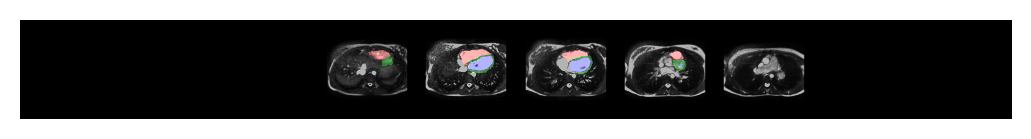

2020-12-02 08:18:03,731 INFO GT on AX


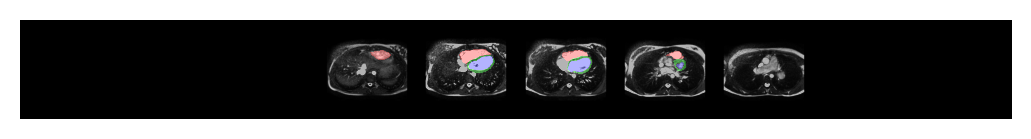

2020-12-02 08:18:04,184 INFO inv mask shape: (20, 288, 288, 4), gt mask shape: (20, 288, 288, 4)
2020-12-02 08:18:04,194 INFO DICE LV: 0.9318480491638184
2020-12-02 08:18:04,201 INFO DICE RV: 0.9180598855018616
2020-12-02 08:18:04,210 INFO DICE MYO: 0.7085480690002441
2020-12-02 08:18:04,251 INFO m: [[ 0.59   -0.7363  0.332  -0.971 ]
 [ 0.26    0.562   0.785  -0.957 ]
 [-0.7646 -0.3767  0.523   7.848 ]]
2020-12-02 08:18:04,252 INFO m_mod: [[ 0.59   -0.7363  0.332  -0.1528]
 [ 0.26    0.562   0.785   0.0573]
 [-0.7646 -0.3767  0.523   1.211 ]]
2020-12-02 08:18:04,252 INFO m_scaled: [[ 0.59   -0.7363  0.332  -0.3057]
 [ 0.26    0.562   0.785   0.1146]
 [-0.7646 -0.3767  0.523   2.422 ]]
2020-12-02 08:18:04,254 INFO 0000-11YU3CUF_2007-12-10_ES_msk.nrrd
2020-12-02 08:18:09,064 INFO DICE LV: 0.8465278148651123
2020-12-02 08:18:09,139 INFO DICE RV: 0.8002396821975708
2020-12-02 08:18:09,208 INFO DICE MYO: 0.740997850894928
2020-12-02 08:18:09,698 INFO Predicted mask rotated to AX on original

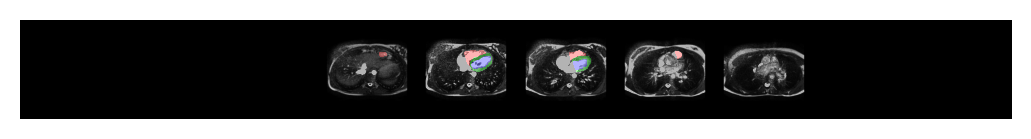

2020-12-02 08:18:10,104 INFO GT on AX


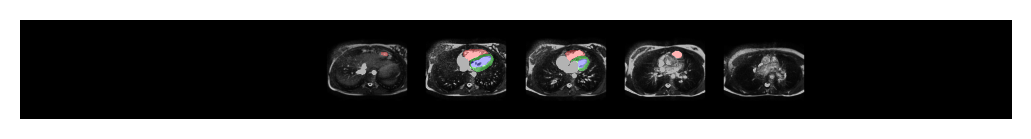

2020-12-02 08:18:10,569 INFO inv mask shape: (20, 288, 288, 4), gt mask shape: (20, 288, 288, 4)
2020-12-02 08:18:10,578 INFO DICE LV: 0.848368227481842
2020-12-02 08:18:10,588 INFO DICE RV: 0.8127908110618591
2020-12-02 08:18:10,598 INFO DICE MYO: 0.7398987412452698
2020-12-02 08:18:10,643 INFO m: [[ 0.59   -0.7363  0.332  -0.971 ]
 [ 0.26    0.562   0.785  -0.957 ]
 [-0.7646 -0.3767  0.523   7.85  ]]
2020-12-02 08:18:10,644 INFO m_mod: [[ 0.59   -0.7363  0.332  -0.1533]
 [ 0.26    0.562   0.785   0.0574]
 [-0.7646 -0.3767  0.523   1.212 ]]
2020-12-02 08:18:10,644 INFO m_scaled: [[ 0.59   -0.7363  0.332  -0.3066]
 [ 0.26    0.562   0.785   0.1148]
 [-0.7646 -0.3767  0.523   2.424 ]]
2020-12-02 08:18:10,645 INFO 0000-1E8MCV9L_2005-12-15_ED_msk.nrrd
2020-12-02 08:18:15,442 INFO DICE LV: 0.8164541125297546
2020-12-02 08:18:15,517 INFO DICE RV: 0.808269739151001
2020-12-02 08:18:15,590 INFO DICE MYO: 0.6263623237609863
2020-12-02 08:18:16,087 INFO Predicted mask rotated to AX on original 

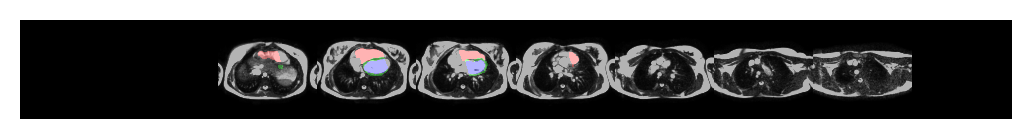

2020-12-02 08:18:16,483 INFO GT on AX


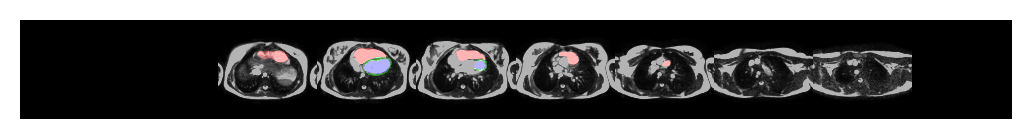

2020-12-02 08:18:16,957 INFO inv mask shape: (28, 256, 256, 4), gt mask shape: (28, 256, 256, 4)
2020-12-02 08:18:16,965 INFO DICE LV: 0.7915767431259155
2020-12-02 08:18:16,972 INFO DICE RV: 0.8025491237640381
2020-12-02 08:18:16,979 INFO DICE MYO: 0.5815744996070862
2020-12-02 08:18:17,021 INFO m: [[ 0.609  -0.7036  0.366  -0.9634]
 [ 0.2534  0.61    0.751  -0.947 ]
 [-0.7515 -0.3645  0.55    7.32  ]]
2020-12-02 08:18:17,022 INFO m_mod: [[ 0.609   -0.7036   0.366   -0.1431 ]
 [ 0.2534   0.61     0.751    0.05325]
 [-0.7515  -0.3645   0.55     1.128  ]]
2020-12-02 08:18:17,022 INFO m_scaled: [[ 0.609  -0.7036  0.366  -0.2861]
 [ 0.2534  0.61    0.751   0.1065]
 [-0.7515 -0.3645  0.55    2.256 ]]
2020-12-02 08:18:17,023 INFO 0000-1E8MCV9L_2005-12-15_ES_msk.nrrd
2020-12-02 08:18:21,730 INFO DICE LV: 0.8452053070068359
2020-12-02 08:18:21,805 INFO DICE RV: 0.6534388661384583
2020-12-02 08:18:21,879 INFO DICE MYO: 0.6823882460594177
2020-12-02 08:18:22,375 INFO Predicted mask rotated to A

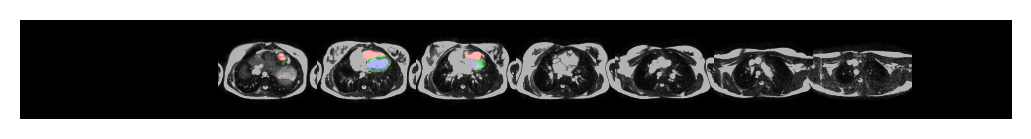

2020-12-02 08:18:22,786 INFO GT on AX


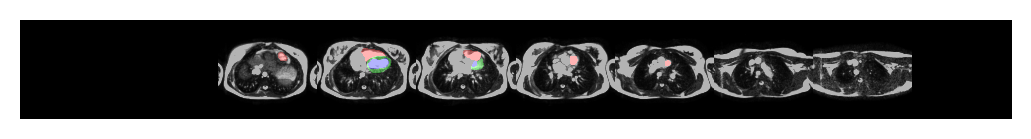

2020-12-02 08:18:23,288 INFO inv mask shape: (28, 256, 256, 4), gt mask shape: (28, 256, 256, 4)
2020-12-02 08:18:23,296 INFO DICE LV: 0.8532467484474182
2020-12-02 08:18:23,303 INFO DICE RV: 0.6882760524749756
2020-12-02 08:18:23,311 INFO DICE MYO: 0.6894922256469727
2020-12-02 08:18:23,357 INFO m: [[ 0.617  -0.689   0.3806 -0.9595]
 [ 0.2505  0.631   0.735  -0.942 ]
 [-0.7456 -0.3582  0.5615  7.1   ]]
2020-12-02 08:18:23,358 INFO m_mod: [[ 0.617   -0.689    0.3806  -0.1392 ]
 [ 0.2505   0.631    0.735    0.05173]
 [-0.7456  -0.3582   0.5615   1.095  ]]
2020-12-02 08:18:23,358 INFO m_scaled: [[ 0.617   -0.689    0.3806  -0.2783 ]
 [ 0.2505   0.631    0.735    0.10345]
 [-0.7456  -0.3582   0.5615   2.19   ]]
2020-12-02 08:18:23,359 INFO 0000-1PFT9CA1_2006-05-17_ED_msk.nrrd
2020-12-02 08:18:29,233 INFO DICE LV: 0.9129742383956909
2020-12-02 08:18:29,301 INFO DICE RV: 0.7822563052177429
2020-12-02 08:18:29,368 INFO DICE MYO: 0.6768946647644043
2020-12-02 08:18:29,854 INFO Predicted mask 

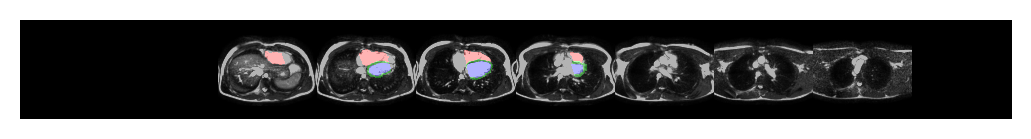

2020-12-02 08:18:30,256 INFO GT on AX


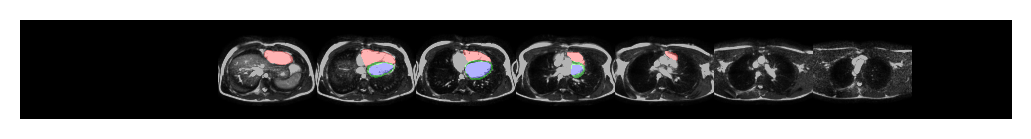

2020-12-02 08:18:30,732 INFO inv mask shape: (26, 256, 256, 4), gt mask shape: (26, 256, 256, 4)
2020-12-02 08:18:30,740 INFO DICE LV: 0.9225167036056519
2020-12-02 08:18:30,748 INFO DICE RV: 0.7949113845825195
2020-12-02 08:18:30,756 INFO DICE MYO: 0.6795812249183655
2020-12-02 08:18:30,797 INFO m: [[ 0.6016 -0.7173  0.3518 -0.967 ]
 [ 0.2566  0.5903  0.7656 -0.951 ]
 [-0.757  -0.37    0.539   7.523 ]]
2020-12-02 08:18:30,797 INFO m_mod: [[ 0.6016 -0.7173  0.3518 -0.147 ]
 [ 0.2566  0.5903  0.7656  0.0548]
 [-0.757  -0.37    0.539   1.159 ]]
2020-12-02 08:18:30,798 INFO m_scaled: [[ 0.6016 -0.7173  0.3518 -0.294 ]
 [ 0.2566  0.5903  0.7656  0.1096]
 [-0.757  -0.37    0.539   2.318 ]]
2020-12-02 08:18:30,799 INFO 0000-1PFT9CA1_2006-05-17_ES_msk.nrrd
2020-12-02 08:18:35,550 INFO DICE LV: 0.8519664406776428
2020-12-02 08:18:35,618 INFO DICE RV: 0.6898669600486755
2020-12-02 08:18:35,683 INFO DICE MYO: 0.6472069025039673
2020-12-02 08:18:36,163 INFO Predicted mask rotated to AX on origina

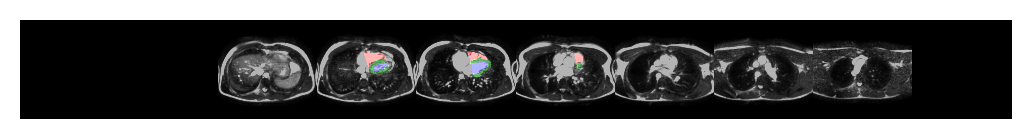

2020-12-02 08:18:36,571 INFO GT on AX


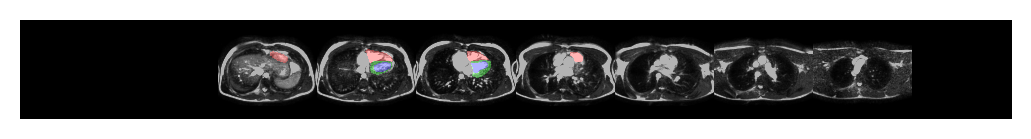

2020-12-02 08:18:37,046 INFO inv mask shape: (26, 256, 256, 4), gt mask shape: (26, 256, 256, 4)
2020-12-02 08:18:37,053 INFO DICE LV: 0.8654577136039734
2020-12-02 08:18:37,060 INFO DICE RV: 0.6945407390594482
2020-12-02 08:18:37,067 INFO DICE MYO: 0.6515965461730957
2020-12-02 08:18:37,107 INFO m: [[ 0.6    -0.7183  0.351  -0.967 ]
 [ 0.2563  0.589   0.766  -0.951 ]
 [-0.7573 -0.37    0.5376  7.54  ]]
2020-12-02 08:18:37,108 INFO m_mod: [[ 0.6    -0.7183  0.351  -0.1475]
 [ 0.2563  0.589   0.766   0.055 ]
 [-0.7573 -0.37    0.5376  1.162 ]]
2020-12-02 08:18:37,109 INFO m_scaled: [[ 0.6    -0.7183  0.351  -0.295 ]
 [ 0.2563  0.589   0.766   0.11  ]
 [-0.7573 -0.37    0.5376  2.324 ]]
2020-12-02 08:18:37,109 INFO 0000-2V8HJLHN_2005-08-30_ED_msk.nrrd
2020-12-02 08:18:41,835 INFO DICE LV: 0.9229854345321655
2020-12-02 08:18:41,903 INFO DICE RV: 0.8538369536399841
2020-12-02 08:18:41,971 INFO DICE MYO: 0.6768935918807983
2020-12-02 08:18:42,444 INFO Predicted mask rotated to AX on origina

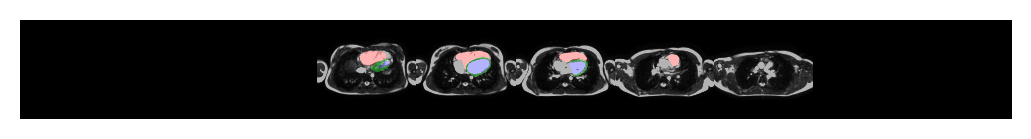

2020-12-02 08:18:42,837 INFO GT on AX


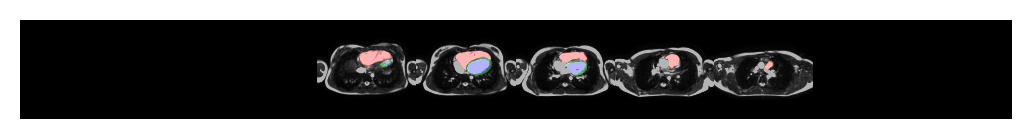

2020-12-02 08:18:43,287 INFO inv mask shape: (21, 256, 256, 4), gt mask shape: (21, 256, 256, 4)
2020-12-02 08:18:43,293 INFO DICE LV: 0.9332742691040039
2020-12-02 08:18:43,299 INFO DICE RV: 0.8558052182197571
2020-12-02 08:18:43,305 INFO DICE MYO: 0.7041975855827332
2020-12-02 08:18:43,345 INFO m: [[ 0.591  -0.7344  0.3335 -0.9707]
 [ 0.26    0.5645  0.783  -0.9565]
 [-0.7637 -0.376   0.5244  7.82  ]]
2020-12-02 08:18:43,345 INFO m_mod: [[ 0.591   -0.7344   0.3335  -0.1523 ]
 [ 0.26     0.5645   0.783    0.05707]
 [-0.7637  -0.376    0.5244   1.206  ]]
2020-12-02 08:18:43,346 INFO m_scaled: [[ 0.591   -0.7344   0.3335  -0.3047 ]
 [ 0.26     0.5645   0.783    0.11414]
 [-0.7637  -0.376    0.5244   2.412  ]]
2020-12-02 08:18:43,346 INFO 0000-2V8HJLHN_2005-08-30_ES_msk.nrrd
2020-12-02 08:18:48,023 INFO DICE LV: 0.8342478275299072
2020-12-02 08:18:48,091 INFO DICE RV: 0.7564435005187988
2020-12-02 08:18:48,160 INFO DICE MYO: 0.6809293031692505
2020-12-02 08:18:48,632 INFO Predicted mask 

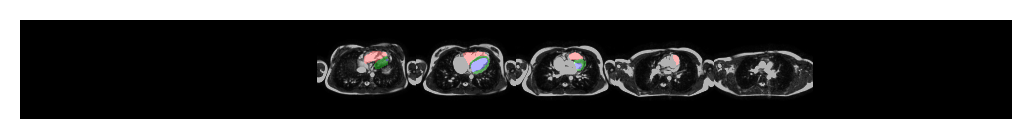

2020-12-02 08:18:49,031 INFO GT on AX


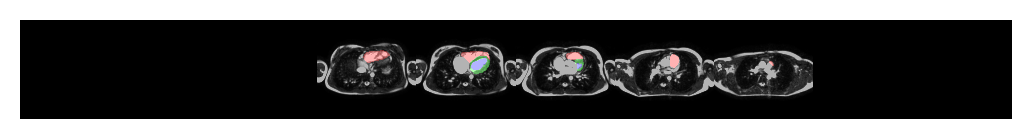

2020-12-02 08:18:49,491 INFO inv mask shape: (21, 256, 256, 4), gt mask shape: (21, 256, 256, 4)
2020-12-02 08:18:49,498 INFO DICE LV: 0.8531103730201721
2020-12-02 08:18:49,504 INFO DICE RV: 0.7609925270080566
2020-12-02 08:18:49,512 INFO DICE MYO: 0.7023744583129883
2020-12-02 08:18:49,552 INFO m: [[ 0.588  -0.74    0.3271 -0.9717]
 [ 0.261   0.556   0.789  -0.958 ]
 [-0.7656 -0.3784  0.52    7.902 ]]
2020-12-02 08:18:49,553 INFO m_mod: [[ 0.588  -0.74    0.3271 -0.1538]
 [ 0.261   0.556   0.789   0.0577]
 [-0.7656 -0.3784  0.52    1.219 ]]
2020-12-02 08:18:49,553 INFO m_scaled: [[ 0.588  -0.74    0.3271 -0.3076]
 [ 0.261   0.556   0.789   0.1154]
 [-0.7656 -0.3784  0.52    2.438 ]]
2020-12-02 08:18:49,554 INFO 0000-2WHFP73X_2007-03-28_ED_msk.nrrd
2020-12-02 08:18:54,344 INFO DICE LV: 0.8928670287132263
2020-12-02 08:18:54,420 INFO DICE RV: 0.8091782331466675
2020-12-02 08:18:54,490 INFO DICE MYO: 0.6919146776199341
2020-12-02 08:18:54,994 INFO Predicted mask rotated to AX on origina

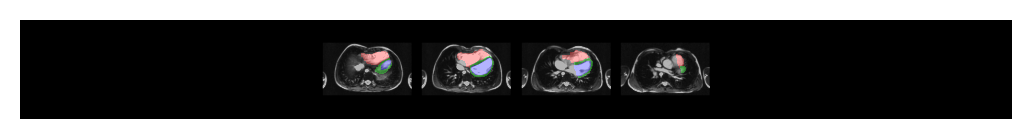

2020-12-02 08:18:55,394 INFO GT on AX


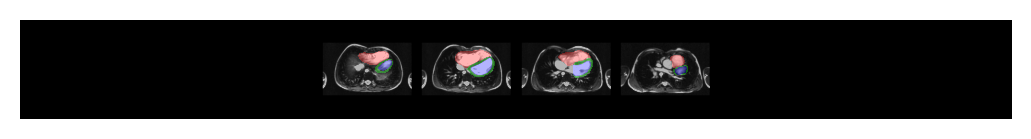

2020-12-02 08:18:55,786 INFO inv mask shape: (17, 114, 192, 4), gt mask shape: (17, 114, 192, 4)
2020-12-02 08:18:55,789 INFO DICE LV: 0.9031527638435364
2020-12-02 08:18:55,791 INFO DICE RV: 0.8082306981086731
2020-12-02 08:18:55,794 INFO DICE MYO: 0.7053316831588745
2020-12-02 08:18:55,838 INFO m: [[ 0.584  -0.747   0.3179 -0.973 ]
 [ 0.2627  0.5444  0.797  -0.96  ]
 [-0.768  -0.3816  0.5137  8.03  ]]
2020-12-02 08:18:55,838 INFO m_mod: [[ 0.584  -0.747   0.3179 -0.1562]
 [ 0.2627  0.5444  0.797   0.0586]
 [-0.768  -0.3816  0.5137  1.239 ]]
2020-12-02 08:18:55,839 INFO m_scaled: [[ 0.584  -0.747   0.3179 -0.3125]
 [ 0.2627  0.5444  0.797   0.1172]
 [-0.768  -0.3816  0.5137  2.479 ]]
2020-12-02 08:18:55,840 INFO 0000-2WHFP73X_2007-03-28_ES_msk.nrrd
2020-12-02 08:19:00,598 INFO DICE LV: 0.7517252564430237
2020-12-02 08:19:00,663 INFO DICE RV: 0.5694625973701477
2020-12-02 08:19:00,728 INFO DICE MYO: 0.6278213262557983
2020-12-02 08:19:01,230 INFO Predicted mask rotated to AX on origina

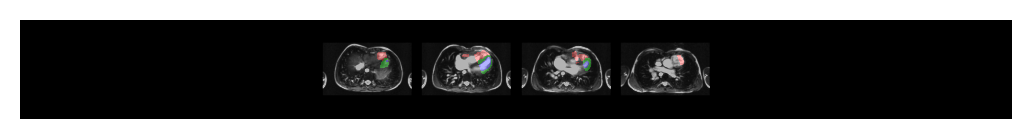

2020-12-02 08:19:01,615 INFO GT on AX


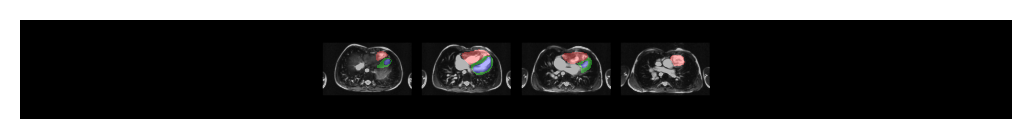

2020-12-02 08:19:02,006 INFO inv mask shape: (17, 114, 192, 4), gt mask shape: (17, 114, 192, 4)
2020-12-02 08:19:02,009 INFO DICE LV: 0.7446675896644592
2020-12-02 08:19:02,011 INFO DICE RV: 0.5682410597801208
2020-12-02 08:19:02,014 INFO DICE MYO: 0.5922696590423584
2020-12-02 08:19:02,054 INFO m: [[ 0.5825 -0.7495  0.3142 -0.9736]
 [ 0.2634  0.54    0.7993 -0.961 ]
 [-0.769  -0.3826  0.5117  8.07  ]]
2020-12-02 08:19:02,054 INFO m_mod: [[ 0.5825  -0.7495   0.3142  -0.1572 ]
 [ 0.2634   0.54     0.7993   0.05893]
 [-0.769   -0.3826   0.5117   1.246  ]]
2020-12-02 08:19:02,055 INFO m_scaled: [[ 0.5825  -0.7495   0.3142  -0.3145 ]
 [ 0.2634   0.54     0.7993   0.11786]
 [-0.769   -0.3826   0.5117   2.492  ]]
2020-12-02 08:19:02,056 INFO 0000-44U3AGET_2006-08-01_ED_msk.nrrd
2020-12-02 08:19:06,732 INFO DICE LV: 0.7785196900367737
2020-12-02 08:19:06,801 INFO DICE RV: 0.666516125202179
2020-12-02 08:19:06,866 INFO DICE MYO: 0.5175663232803345
2020-12-02 08:19:07,346 INFO Predicted mask r

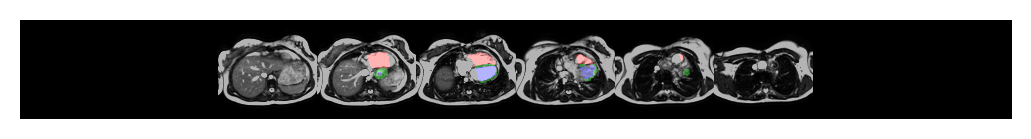

2020-12-02 08:19:07,740 INFO GT on AX


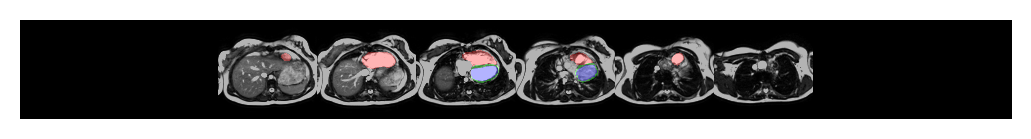

2020-12-02 08:19:08,186 INFO inv mask shape: (22, 256, 256, 4), gt mask shape: (22, 256, 256, 4)
2020-12-02 08:19:08,194 INFO DICE LV: 0.7983752489089966
2020-12-02 08:19:08,199 INFO DICE RV: 0.6828476190567017
2020-12-02 08:19:08,205 INFO DICE MYO: 0.5406134724617004
2020-12-02 08:19:08,245 INFO m: [[ 0.5938 -0.73    0.3384 -0.9697]
 [ 0.2593  0.572   0.779  -0.955 ]
 [-0.7617 -0.3745  0.529   7.73  ]]
2020-12-02 08:19:08,245 INFO m_mod: [[ 0.5938  -0.73     0.3384  -0.1509 ]
 [ 0.2593   0.572    0.779    0.05643]
 [-0.7617  -0.3745   0.529    1.191  ]]
2020-12-02 08:19:08,246 INFO m_scaled: [[ 0.5938  -0.73     0.3384  -0.3018 ]
 [ 0.2593   0.572    0.779    0.11285]
 [-0.7617  -0.3745   0.529    2.383  ]]
2020-12-02 08:19:08,247 INFO 0000-44U3AGET_2006-08-01_ES_msk.nrrd
2020-12-02 08:19:12,956 INFO DICE LV: 0.8477662801742554
2020-12-02 08:19:13,039 INFO DICE RV: 0.6251442432403564
2020-12-02 08:19:13,112 INFO DICE MYO: 0.595808207988739
2020-12-02 08:19:13,614 INFO Predicted mask r

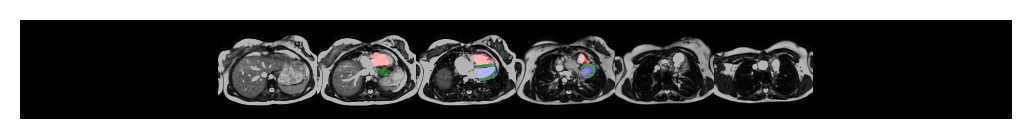

2020-12-02 08:19:14,009 INFO GT on AX


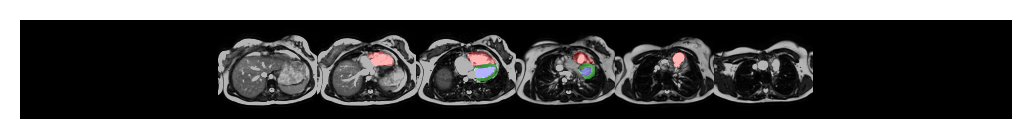

2020-12-02 08:19:14,465 INFO inv mask shape: (22, 256, 256, 4), gt mask shape: (22, 256, 256, 4)
2020-12-02 08:19:14,471 INFO DICE LV: 0.850103497505188
2020-12-02 08:19:14,477 INFO DICE RV: 0.633527398109436
2020-12-02 08:19:14,483 INFO DICE MYO: 0.6018663644790649
2020-12-02 08:19:14,531 INFO m: [[ 0.601  -0.717   0.354  -0.9663]
 [ 0.256   0.592   0.7646 -0.951 ]
 [-0.7573 -0.3687  0.5396  7.523 ]]
2020-12-02 08:19:14,532 INFO m_mod: [[ 0.601   -0.717    0.354   -0.147  ]
 [ 0.256    0.592    0.7646   0.05502]
 [-0.7573  -0.3687   0.5396   1.16   ]]
2020-12-02 08:19:14,533 INFO m_scaled: [[ 0.601   -0.717    0.354   -0.294  ]
 [ 0.256    0.592    0.7646   0.11005]
 [-0.7573  -0.3687   0.5396   2.32   ]]
2020-12-02 08:19:14,533 INFO 0000-49RHVC6C_2005-11-22_ED_msk.nrrd
2020-12-02 08:19:20,229 INFO DICE LV: 0.9295098185539246
2020-12-02 08:19:20,303 INFO DICE RV: 0.8664406538009644
2020-12-02 08:19:20,376 INFO DICE MYO: 0.6888281106948853
2020-12-02 08:19:20,872 INFO Predicted mask ro

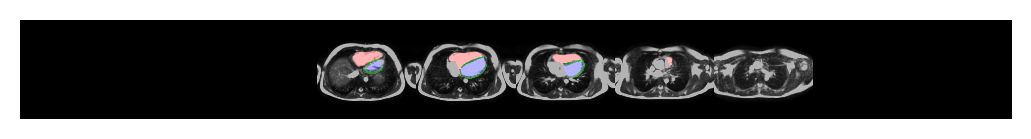

2020-12-02 08:19:21,264 INFO GT on AX


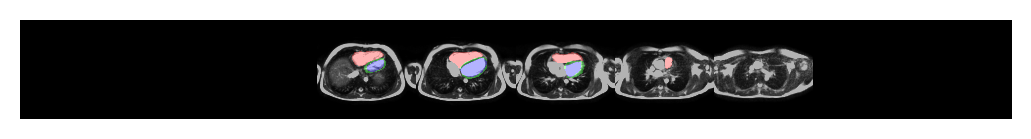

2020-12-02 08:19:21,714 INFO inv mask shape: (22, 256, 256, 4), gt mask shape: (22, 256, 256, 4)
2020-12-02 08:19:21,721 INFO DICE LV: 0.9293138384819031
2020-12-02 08:19:21,728 INFO DICE RV: 0.8702763319015503
2020-12-02 08:19:21,735 INFO DICE MYO: 0.7008784413337708
2020-12-02 08:19:21,782 INFO m: [[ 0.614  -0.6943  0.3757 -0.961 ]
 [ 0.2517  0.6235  0.74   -0.944 ]
 [-0.748  -0.3599  0.5576  7.184 ]]
2020-12-02 08:19:21,783 INFO m_mod: [[ 0.614  -0.6943  0.3757 -0.1411]
 [ 0.2517  0.6235  0.74    0.0524]
 [-0.748  -0.3599  0.5576  1.107 ]]
2020-12-02 08:19:21,783 INFO m_scaled: [[ 0.614  -0.6943  0.3757 -0.2822]
 [ 0.2517  0.6235  0.74    0.1048]
 [-0.748  -0.3599  0.5576  2.215 ]]
2020-12-02 08:19:21,784 INFO 0000-49RHVC6C_2005-11-22_ES_msk.nrrd
2020-12-02 08:19:26,475 INFO DICE LV: 0.8556267023086548
2020-12-02 08:19:26,550 INFO DICE RV: 0.7421261072158813
2020-12-02 08:19:26,622 INFO DICE MYO: 0.697635293006897
2020-12-02 08:19:27,126 INFO Predicted mask rotated to AX on original

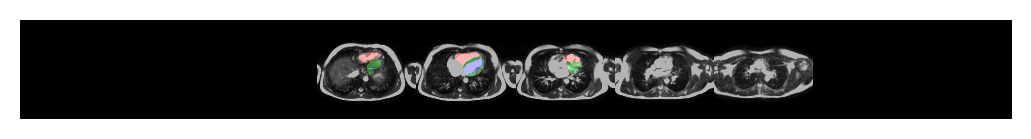

2020-12-02 08:19:27,519 INFO GT on AX


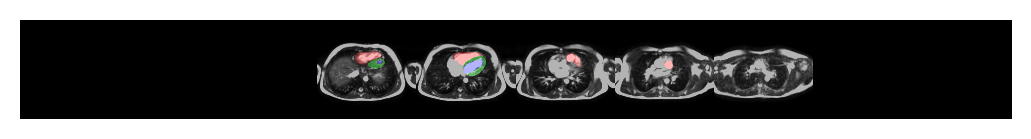

2020-12-02 08:19:27,969 INFO inv mask shape: (22, 256, 256, 4), gt mask shape: (22, 256, 256, 4)
2020-12-02 08:19:27,976 INFO DICE LV: 0.8699944615364075
2020-12-02 08:19:27,982 INFO DICE RV: 0.7535785436630249
2020-12-02 08:19:27,987 INFO DICE MYO: 0.7164537906646729
2020-12-02 08:19:28,035 INFO m: [[ 0.608  -0.704   0.3662 -0.9634]
 [ 0.2534  0.6094  0.751  -0.9473]
 [-0.7524 -0.3638  0.549   7.34  ]]
2020-12-02 08:19:28,036 INFO m_mod: [[ 0.608   -0.704    0.3662  -0.144  ]
 [ 0.2534   0.6094   0.751    0.05356]
 [-0.7524  -0.3638   0.549    1.132  ]]
2020-12-02 08:19:28,036 INFO m_scaled: [[ 0.608  -0.704   0.3662 -0.288 ]
 [ 0.2534  0.6094  0.751   0.1071]
 [-0.7524 -0.3638  0.549   2.264 ]]
2020-12-02 08:19:28,037 INFO 0000-76RJ3Z26_2006-11-23_ED_msk.nrrd
2020-12-02 08:19:32,740 INFO DICE LV: 0.7727726101875305
2020-12-02 08:19:32,823 INFO DICE RV: 0.7116398811340332
2020-12-02 08:19:32,902 INFO DICE MYO: 0.5272800326347351
2020-12-02 08:19:33,423 INFO Predicted mask rotated to A

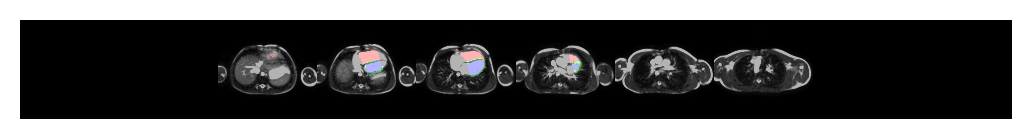

2020-12-02 08:19:33,814 INFO GT on AX


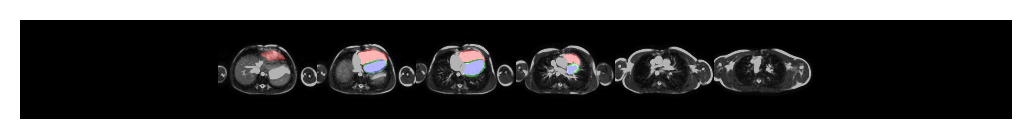

2020-12-02 08:19:34,332 INFO inv mask shape: (24, 256, 256, 4), gt mask shape: (24, 256, 256, 4)
2020-12-02 08:19:34,340 INFO DICE LV: 0.7380505800247192
2020-12-02 08:19:34,347 INFO DICE RV: 0.741688072681427
2020-12-02 08:19:34,355 INFO DICE MYO: 0.46550264954566956
2020-12-02 08:19:34,410 INFO m: [[ 0.5977 -0.722   0.3467 -0.968 ]
 [ 0.2573  0.583   0.77   -0.9526]
 [-0.759  -0.371   0.5347  7.613 ]]
2020-12-02 08:19:34,410 INFO m_mod: [[ 0.5977  -0.722    0.3467  -0.1489 ]
 [ 0.2573   0.583    0.77     0.05554]
 [-0.759   -0.371    0.5347   1.175  ]]
2020-12-02 08:19:34,411 INFO m_scaled: [[ 0.5977 -0.722   0.3467 -0.2979]
 [ 0.2573  0.583   0.77    0.1111]
 [-0.759  -0.371   0.5347  2.35  ]]
2020-12-02 08:19:34,412 INFO 0000-76RJ3Z26_2006-11-23_ES_msk.nrrd
2020-12-02 08:19:39,128 INFO DICE LV: 0.8494405746459961
2020-12-02 08:19:39,209 INFO DICE RV: 0.6293631196022034
2020-12-02 08:19:39,291 INFO DICE MYO: 0.6555083990097046
2020-12-02 08:19:39,812 INFO Predicted mask rotated to A

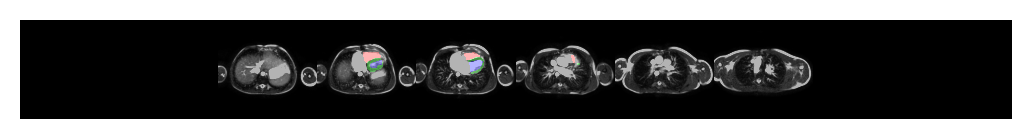

2020-12-02 08:19:40,203 INFO GT on AX


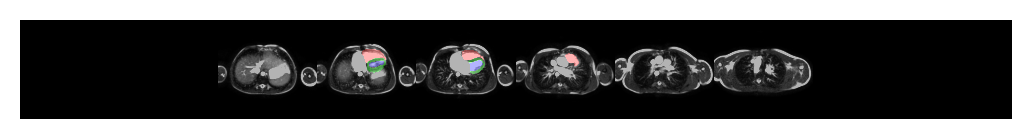

2020-12-02 08:19:40,711 INFO inv mask shape: (24, 256, 256, 4), gt mask shape: (24, 256, 256, 4)
2020-12-02 08:19:40,720 INFO DICE LV: 0.8796184659004211
2020-12-02 08:19:40,727 INFO DICE RV: 0.6434857249259949
2020-12-02 08:19:40,735 INFO DICE MYO: 0.6747094392776489
2020-12-02 08:19:40,790 INFO m: [[ 0.595  -0.727   0.3418 -0.9688]
 [ 0.2583  0.576   0.7754 -0.954 ]
 [-0.7607 -0.3733  0.531   7.695 ]]
2020-12-02 08:19:40,790 INFO m_mod: [[ 0.595   -0.727    0.3418  -0.1504 ]
 [ 0.2583   0.576    0.7754   0.05612]
 [-0.7607  -0.3733   0.531    1.187  ]]
2020-12-02 08:19:40,791 INFO m_scaled: [[ 0.595   -0.727    0.3418  -0.3008 ]
 [ 0.2583   0.576    0.7754   0.11224]
 [-0.7607  -0.3733   0.531    2.373  ]]
2020-12-02 08:19:40,792 INFO 0000-8J5NZ5G7_2008-03-27_ED_msk.nrrd
2020-12-02 08:19:45,561 INFO DICE LV: 0.8707799911499023
2020-12-02 08:19:45,648 INFO DICE RV: 0.8287112712860107
2020-12-02 08:19:45,727 INFO DICE MYO: 0.595144510269165
2020-12-02 08:19:46,233 INFO Predicted mask r

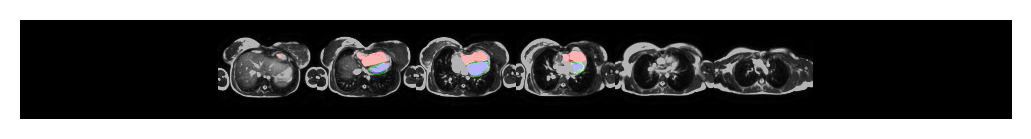

2020-12-02 08:19:46,625 INFO GT on AX


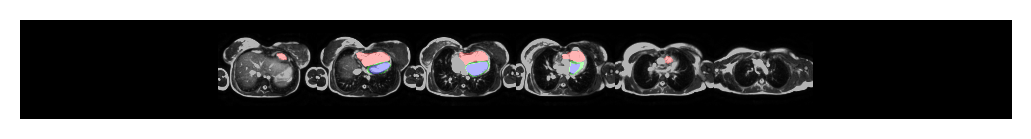

2020-12-02 08:19:47,137 INFO inv mask shape: (24, 256, 256, 4), gt mask shape: (24, 256, 256, 4)
2020-12-02 08:19:47,145 INFO DICE LV: 0.8890380859375
2020-12-02 08:19:47,153 INFO DICE RV: 0.8320426344871521
2020-12-02 08:19:47,162 INFO DICE MYO: 0.6219461560249329
2020-12-02 08:19:47,216 INFO m: [[ 0.595  -0.7275  0.3416 -0.969 ]
 [ 0.2583  0.576   0.776  -0.9546]
 [-0.7607 -0.3735  0.531   7.7   ]]
2020-12-02 08:19:47,216 INFO m_mod: [[ 0.595   -0.7275   0.3416  -0.1504 ]
 [ 0.2583   0.576    0.776    0.05618]
 [-0.7607  -0.3735   0.531    1.1875 ]]
2020-12-02 08:19:47,217 INFO m_scaled: [[ 0.595   -0.7275   0.3416  -0.3008 ]
 [ 0.2583   0.576    0.776    0.11237]
 [-0.7607  -0.3735   0.531    2.375  ]]
2020-12-02 08:19:47,218 INFO 0000-8J5NZ5G7_2008-03-27_ES_msk.nrrd
2020-12-02 08:19:51,979 INFO DICE LV: 0.8690360188484192
2020-12-02 08:19:52,060 INFO DICE RV: 0.7515344023704529
2020-12-02 08:19:52,139 INFO DICE MYO: 0.705199122428894
2020-12-02 08:19:52,638 INFO Predicted mask rota

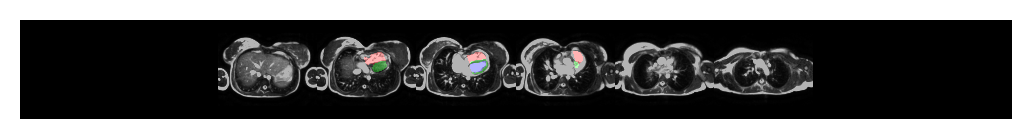

2020-12-02 08:19:53,045 INFO GT on AX


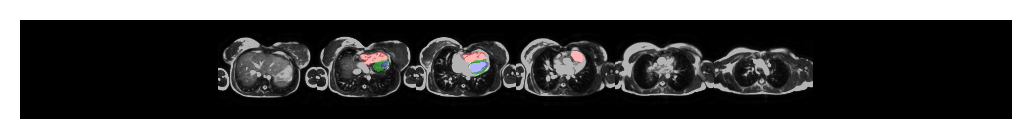

2020-12-02 08:19:53,554 INFO inv mask shape: (24, 256, 256, 4), gt mask shape: (24, 256, 256, 4)
2020-12-02 08:19:53,561 INFO DICE LV: 0.8785918354988098
2020-12-02 08:19:53,567 INFO DICE RV: 0.7385483980178833
2020-12-02 08:19:53,573 INFO DICE MYO: 0.7426270246505737
2020-12-02 08:19:53,627 INFO m: [[ 0.5938 -0.729   0.3396 -0.969 ]
 [ 0.259   0.573   0.7773 -0.9546]
 [-0.7617 -0.3735  0.5293  7.723 ]]
2020-12-02 08:19:53,628 INFO m_mod: [[ 0.5938 -0.729   0.3396 -0.1509]
 [ 0.259   0.573   0.7773  0.0564]
 [-0.7617 -0.3735  0.5293  1.19  ]]
2020-12-02 08:19:53,628 INFO m_scaled: [[ 0.5938 -0.729   0.3396 -0.3018]
 [ 0.259   0.573   0.7773  0.1128]
 [-0.7617 -0.3735  0.5293  2.38  ]]
2020-12-02 08:19:53,629 INFO 0000-9A8UTCZ4_2007-03-16_ED_msk.nrrd
2020-12-02 08:19:58,387 INFO DICE LV: 0.8953271508216858
2020-12-02 08:19:58,467 INFO DICE RV: 0.8592178225517273
2020-12-02 08:19:58,547 INFO DICE MYO: 0.6588173508644104
2020-12-02 08:19:59,064 INFO Predicted mask rotated to AX on origina

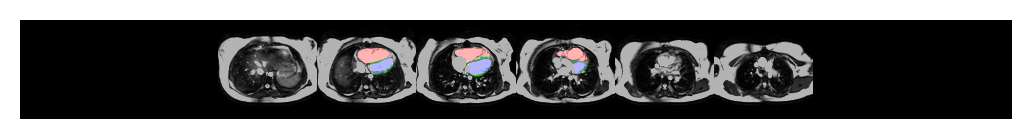

2020-12-02 08:19:59,455 INFO GT on AX


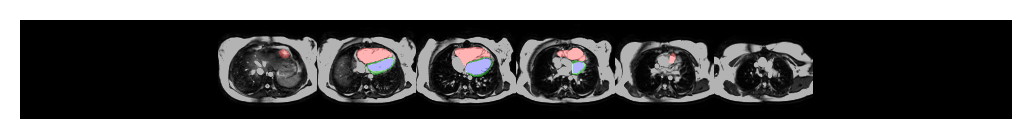

2020-12-02 08:19:59,953 INFO inv mask shape: (22, 256, 256, 4), gt mask shape: (22, 256, 256, 4)
2020-12-02 08:19:59,960 INFO DICE LV: 0.8953326344490051
2020-12-02 08:19:59,967 INFO DICE RV: 0.8788058161735535
2020-12-02 08:19:59,974 INFO DICE MYO: 0.6487482190132141
2020-12-02 08:20:00,028 INFO m: [[ 0.5957 -0.7275  0.341  -0.9688]
 [ 0.2585  0.5757  0.776  -0.954 ]
 [-0.7607 -0.3743  0.531   7.68  ]]
2020-12-02 08:20:00,029 INFO m_mod: [[ 0.5957  -0.7275   0.341   -0.1494 ]
 [ 0.2585   0.5757   0.776    0.05588]
 [-0.7607  -0.3743   0.531    1.183  ]]
2020-12-02 08:20:00,029 INFO m_scaled: [[ 0.5957  -0.7275   0.341   -0.2988 ]
 [ 0.2585   0.5757   0.776    0.11176]
 [-0.7607  -0.3743   0.531    2.365  ]]
2020-12-02 08:20:00,031 INFO 0000-9A8UTCZ4_2007-03-16_ES_msk.nrrd
2020-12-02 08:20:04,747 INFO DICE LV: 0.8382585644721985
2020-12-02 08:20:04,827 INFO DICE RV: 0.6466556787490845
2020-12-02 08:20:04,907 INFO DICE MYO: 0.682950496673584
2020-12-02 08:20:05,410 INFO Predicted mask r

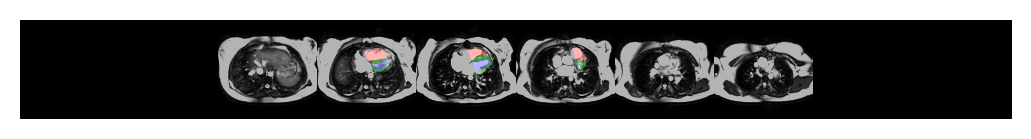

2020-12-02 08:20:05,800 INFO GT on AX


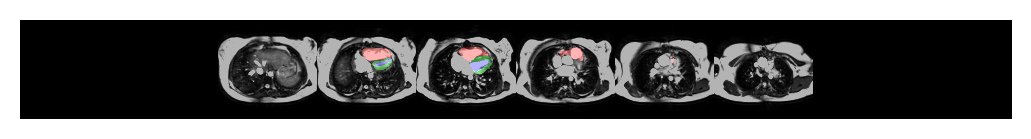

2020-12-02 08:20:06,298 INFO inv mask shape: (22, 256, 256, 4), gt mask shape: (22, 256, 256, 4)
2020-12-02 08:20:06,305 INFO DICE LV: 0.843611478805542
2020-12-02 08:20:06,312 INFO DICE RV: 0.6459739208221436
2020-12-02 08:20:06,319 INFO DICE MYO: 0.6784560680389404
2020-12-02 08:20:06,372 INFO m: [[ 0.5913 -0.7344  0.3333 -0.97  ]
 [ 0.26    0.565   0.783  -0.956 ]
 [-0.763  -0.3767  0.525   7.793 ]]
2020-12-02 08:20:06,373 INFO m_mod: [[ 0.5913 -0.7344  0.3333 -0.1519]
 [ 0.26    0.565   0.783   0.0568]
 [-0.763  -0.3767  0.525   1.2   ]]
2020-12-02 08:20:06,373 INFO m_scaled: [[ 0.5913 -0.7344  0.3333 -0.3037]
 [ 0.26    0.565   0.783   0.1136]
 [-0.763  -0.3767  0.525   2.4   ]]
2020-12-02 08:20:06,374 INFO 0000-9MTQG5XR_2005-05-23_ED_msk.nrrd
2020-12-02 08:20:11,146 INFO DICE LV: 0.8911726474761963
2020-12-02 08:20:11,227 INFO DICE RV: 0.8322191834449768
2020-12-02 08:20:11,308 INFO DICE MYO: 0.6462912559509277
2020-12-02 08:20:11,810 INFO Predicted mask rotated to AX on original

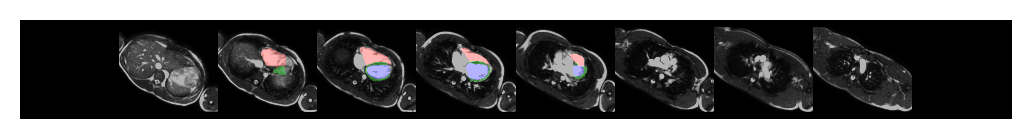

2020-12-02 08:20:12,223 INFO GT on AX


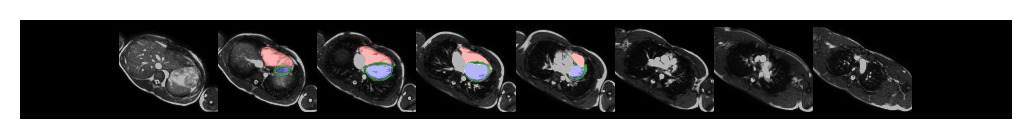

2020-12-02 08:20:12,740 INFO inv mask shape: (20, 256, 256, 4), gt mask shape: (20, 256, 256, 4)
2020-12-02 08:20:12,747 INFO DICE LV: 0.8869730830192566
2020-12-02 08:20:12,753 INFO DICE RV: 0.8380277752876282
2020-12-02 08:20:12,760 INFO DICE MYO: 0.6396602392196655
2020-12-02 08:20:12,815 INFO m: [[ 0.613  -0.697   0.3733 -0.9614]
 [ 0.2524  0.6196  0.743  -0.9443]
 [-0.749  -0.361   0.5557  7.215 ]]
2020-12-02 08:20:12,816 INFO m_mod: [[ 0.613   -0.697    0.3733  -0.1416 ]
 [ 0.2524   0.6196   0.743    0.05267]
 [-0.749   -0.361    0.5557   1.112  ]]
2020-12-02 08:20:12,817 INFO m_scaled: [[ 0.613   -0.697    0.3733  -0.2832 ]
 [ 0.2524   0.6196   0.743    0.10535]
 [-0.749   -0.361    0.5557   2.225  ]]
2020-12-02 08:20:12,817 INFO 0000-9MTQG5XR_2005-05-23_ES_msk.nrrd
2020-12-02 08:20:20,882 INFO DICE LV: 0.8603732585906982
2020-12-02 08:20:20,950 INFO DICE RV: 0.783469557762146
2020-12-02 08:20:21,016 INFO DICE MYO: 0.7134761214256287
2020-12-02 08:20:21,487 INFO Predicted mask r

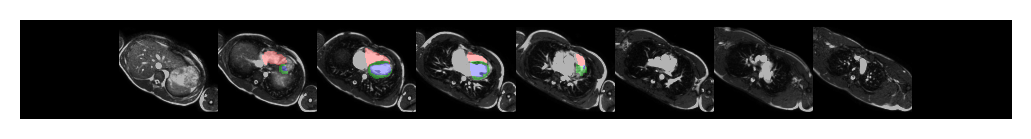

2020-12-02 08:20:21,891 INFO GT on AX


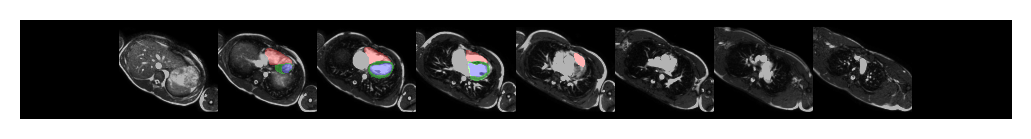

2020-12-02 08:20:22,365 INFO inv mask shape: (20, 256, 256, 4), gt mask shape: (20, 256, 256, 4)
2020-12-02 08:20:22,372 INFO DICE LV: 0.8525826334953308
2020-12-02 08:20:22,378 INFO DICE RV: 0.7781271934509277
2020-12-02 08:20:22,385 INFO DICE MYO: 0.7051129341125488
2020-12-02 08:20:22,425 INFO m: [[ 0.605  -0.7104  0.3599 -0.965 ]
 [ 0.2551  0.6006  0.7573 -0.9487]
 [-0.7544 -0.3665  0.545   7.418 ]]
2020-12-02 08:20:22,426 INFO m_mod: [[ 0.605   -0.7104   0.3599  -0.145  ]
 [ 0.2551   0.6006   0.7573   0.05414]
 [-0.7544  -0.3665   0.545    1.144  ]]
2020-12-02 08:20:22,427 INFO m_scaled: [[ 0.605  -0.7104  0.3599 -0.29  ]
 [ 0.2551  0.6006  0.7573  0.1083]
 [-0.7544 -0.3665  0.545   2.287 ]]
2020-12-02 08:20:22,428 INFO 0000-CKFQTQ9F_2006-11-10_ED_msk.nrrd
2020-12-02 08:20:27,410 INFO DICE LV: 0.9290192723274231
2020-12-02 08:20:27,478 INFO DICE RV: 0.8665156960487366
2020-12-02 08:20:27,543 INFO DICE MYO: 0.7283714413642883
2020-12-02 08:20:28,041 INFO Predicted mask rotated to A

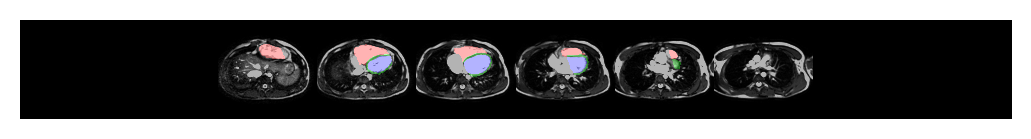

2020-12-02 08:20:28,447 INFO GT on AX


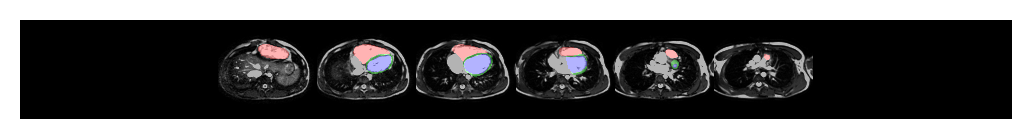

2020-12-02 08:20:28,921 INFO inv mask shape: (25, 256, 256, 4), gt mask shape: (25, 256, 256, 4)
2020-12-02 08:20:28,929 INFO DICE LV: 0.9362233281135559
2020-12-02 08:20:28,936 INFO DICE RV: 0.8732300400733948
2020-12-02 08:20:28,944 INFO DICE MYO: 0.7344102263450623
2020-12-02 08:20:28,984 INFO m: [[ 0.5938 -0.73    0.3384 -0.9697]
 [ 0.2593  0.572   0.779  -0.955 ]
 [-0.7617 -0.3745  0.529   7.73  ]]
2020-12-02 08:20:28,985 INFO m_mod: [[ 0.5938  -0.73     0.3384  -0.1509 ]
 [ 0.2593   0.572    0.779    0.05643]
 [-0.7617  -0.3745   0.529    1.191  ]]
2020-12-02 08:20:28,985 INFO m_scaled: [[ 0.5938  -0.73     0.3384  -0.3018 ]
 [ 0.2593   0.572    0.779    0.11285]
 [-0.7617  -0.3745   0.529    2.383  ]]
2020-12-02 08:20:28,986 INFO 0000-CKFQTQ9F_2006-11-10_ES_msk.nrrd
2020-12-02 08:20:33,840 INFO DICE LV: 0.8755577802658081
2020-12-02 08:20:33,907 INFO DICE RV: 0.7663975358009338
2020-12-02 08:20:33,974 INFO DICE MYO: 0.7662697434425354
2020-12-02 08:20:34,447 INFO Predicted mask 

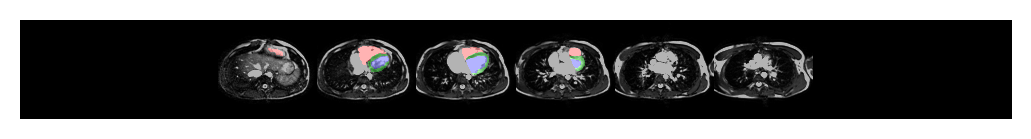

2020-12-02 08:20:34,842 INFO GT on AX


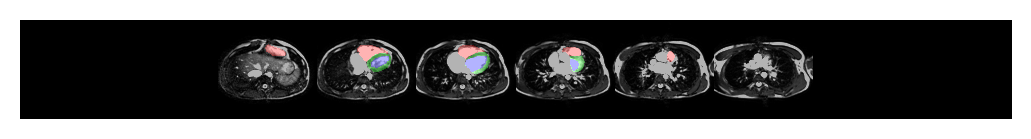

2020-12-02 08:20:35,293 INFO inv mask shape: (25, 256, 256, 4), gt mask shape: (25, 256, 256, 4)
2020-12-02 08:20:35,301 INFO DICE LV: 0.8782516717910767
2020-12-02 08:20:35,309 INFO DICE RV: 0.7718894481658936
2020-12-02 08:20:35,316 INFO DICE MYO: 0.7605918049812317
2020-12-02 08:20:35,356 INFO m: [[ 0.5977 -0.724   0.3445 -0.9683]
 [ 0.258   0.58    0.772  -0.953 ]
 [-0.7593 -0.3726  0.5337  7.633 ]]
2020-12-02 08:20:35,357 INFO m_mod: [[ 0.5977  -0.724    0.3445  -0.1489 ]
 [ 0.258    0.58     0.772    0.05573]
 [-0.7593  -0.3726   0.5337   1.176  ]]
2020-12-02 08:20:35,357 INFO m_scaled: [[ 0.5977  -0.724    0.3445  -0.2979 ]
 [ 0.258    0.58     0.772    0.11145]
 [-0.7593  -0.3726   0.5337   2.352  ]]
2020-12-02 08:20:35,358 INFO 0000-CUKYUVC2_2006-09-20_ED_msk.nrrd
2020-12-02 08:20:40,169 INFO DICE LV: 0.8825687766075134
2020-12-02 08:20:40,240 INFO DICE RV: 0.8608410358428955
2020-12-02 08:20:40,305 INFO DICE MYO: 0.6392519474029541
2020-12-02 08:20:40,782 INFO Predicted mask 

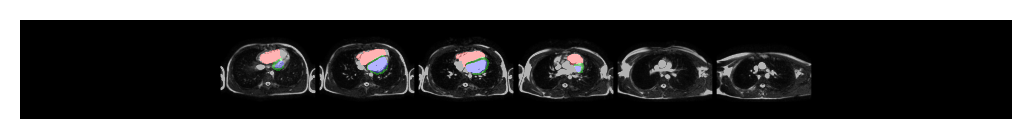

2020-12-02 08:20:41,181 INFO GT on AX


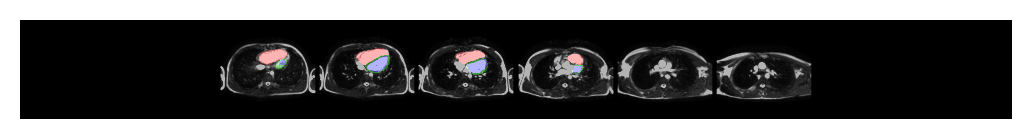

2020-12-02 08:20:41,639 INFO inv mask shape: (24, 256, 256, 4), gt mask shape: (24, 256, 256, 4)
2020-12-02 08:20:41,646 INFO DICE LV: 0.8889333605766296
2020-12-02 08:20:41,654 INFO DICE RV: 0.8615204095840454
2020-12-02 08:20:41,661 INFO DICE MYO: 0.6690051555633545
2020-12-02 08:20:41,701 INFO m: [[ 0.5913 -0.735   0.334  -0.97  ]
 [ 0.2603  0.565   0.7837 -0.956 ]
 [-0.7637 -0.3762  0.5254  7.805 ]]
2020-12-02 08:20:41,702 INFO m_mod: [[ 0.5913  -0.735    0.334   -0.1523 ]
 [ 0.2603   0.565    0.7837   0.05692]
 [-0.7637  -0.3762   0.5254   1.203  ]]
2020-12-02 08:20:41,702 INFO m_scaled: [[ 0.5913  -0.735    0.334   -0.3047 ]
 [ 0.2603   0.565    0.7837   0.11383]
 [-0.7637  -0.3762   0.5254   2.406  ]]
2020-12-02 08:20:41,703 INFO 0000-CUKYUVC2_2006-09-20_ES_msk.nrrd
2020-12-02 08:20:46,479 INFO DICE LV: 0.8435384631156921
2020-12-02 08:20:46,548 INFO DICE RV: 0.8435815572738647
2020-12-02 08:20:46,614 INFO DICE MYO: 0.6889346241950989
2020-12-02 08:20:47,090 INFO Predicted mask 

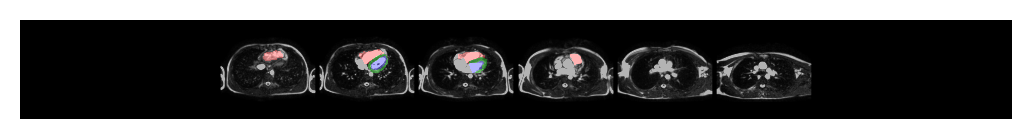

2020-12-02 08:20:47,490 INFO GT on AX


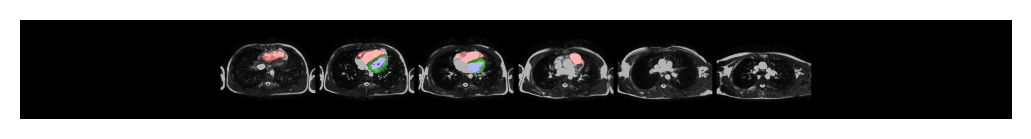

2020-12-02 08:20:47,957 INFO inv mask shape: (24, 256, 256, 4), gt mask shape: (24, 256, 256, 4)
2020-12-02 08:20:47,964 INFO DICE LV: 0.854293942451477
2020-12-02 08:20:47,970 INFO DICE RV: 0.8554949164390564
2020-12-02 08:20:47,976 INFO DICE MYO: 0.686312735080719
2020-12-02 08:20:48,017 INFO m: [[ 0.5874 -0.74    0.326  -0.9717]
 [ 0.2612  0.555   0.789  -0.958 ]
 [-0.7656 -0.3787  0.5195  7.914 ]]
2020-12-02 08:20:48,017 INFO m_mod: [[ 0.5874  -0.74     0.326   -0.1543 ]
 [ 0.2612   0.555    0.789    0.05774]
 [-0.7656  -0.3787   0.5195   1.221  ]]
2020-12-02 08:20:48,018 INFO m_scaled: [[ 0.5874 -0.74    0.326  -0.3086]
 [ 0.2612  0.555   0.789   0.1155]
 [-0.7656 -0.3787  0.5195  2.441 ]]
2020-12-02 08:20:48,019 INFO 0000-D9HN2LZW_2007-03-23_ED_msk.nrrd
2020-12-02 08:20:52,735 INFO DICE LV: 0.9031806588172913
2020-12-02 08:20:52,804 INFO DICE RV: 0.750607967376709
2020-12-02 08:20:52,871 INFO DICE MYO: 0.6779921054840088
2020-12-02 08:20:53,356 INFO Predicted mask rotated to AX o

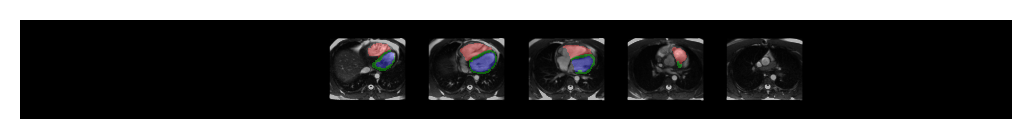

2020-12-02 08:20:53,752 INFO GT on AX


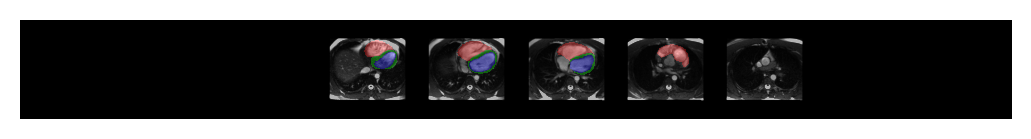

2020-12-02 08:20:54,164 INFO inv mask shape: (20, 156, 192, 4), gt mask shape: (20, 156, 192, 4)
2020-12-02 08:20:54,168 INFO DICE LV: 0.9117313623428345
2020-12-02 08:20:54,171 INFO DICE RV: 0.7528411149978638
2020-12-02 08:20:54,175 INFO DICE MYO: 0.6760130524635315
2020-12-02 08:20:54,216 INFO m: [[ 0.6064 -0.707   0.3645 -0.9644]
 [ 0.2544  0.6064  0.7534 -0.948 ]
 [-0.7534 -0.3643  0.5474  7.383 ]]
2020-12-02 08:20:54,216 INFO m_mod: [[ 0.6064  -0.707    0.3645  -0.145  ]
 [ 0.2544   0.6064   0.7534   0.05392]
 [-0.7534  -0.3643   0.5474   1.14   ]]
2020-12-02 08:20:54,217 INFO m_scaled: [[ 0.6064  -0.707    0.3645  -0.29   ]
 [ 0.2544   0.6064   0.7534   0.10785]
 [-0.7534  -0.3643   0.5474   2.28   ]]
2020-12-02 08:20:54,218 INFO 0000-D9HN2LZW_2007-03-23_ES_msk.nrrd
2020-12-02 08:20:58,911 INFO DICE LV: 0.8253336548805237
2020-12-02 08:20:58,979 INFO DICE RV: 0.6098712086677551
2020-12-02 08:20:59,044 INFO DICE MYO: 0.7232571244239807
2020-12-02 08:20:59,518 INFO Predicted mask 

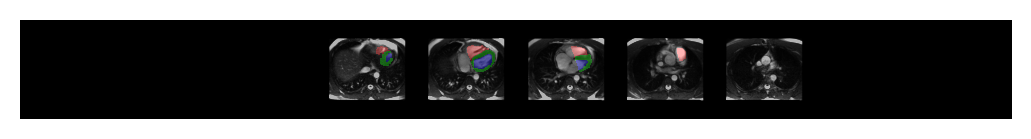

2020-12-02 08:20:59,911 INFO GT on AX


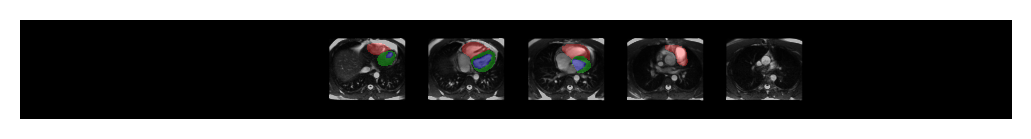

2020-12-02 08:21:00,310 INFO inv mask shape: (20, 156, 192, 4), gt mask shape: (20, 156, 192, 4)
2020-12-02 08:21:00,314 INFO DICE LV: 0.8471500873565674
2020-12-02 08:21:00,317 INFO DICE RV: 0.6115207672119141
2020-12-02 08:21:00,320 INFO DICE MYO: 0.7354872226715088
2020-12-02 08:21:00,361 INFO m: [[ 0.6045 -0.7095  0.3616 -0.965 ]
 [ 0.255   0.6025  0.756  -0.9487]
 [-0.7544 -0.365   0.5454  7.426 ]]
2020-12-02 08:21:00,362 INFO m_mod: [[ 0.6045 -0.7095  0.3616 -0.1455]
 [ 0.255   0.6025  0.756   0.0543]
 [-0.7544 -0.365   0.5454  1.146 ]]
2020-12-02 08:21:00,362 INFO m_scaled: [[ 0.6045 -0.7095  0.3616 -0.291 ]
 [ 0.255   0.6025  0.756   0.1086]
 [-0.7544 -0.365   0.5454  2.293 ]]
2020-12-02 08:21:00,363 INFO 0000-E18NUCU2_2005-05-19_ED_msk.nrrd
2020-12-02 08:21:05,051 INFO DICE LV: 0.9248299598693848
2020-12-02 08:21:05,119 INFO DICE RV: 0.8811699151992798
2020-12-02 08:21:05,184 INFO DICE MYO: 0.6706827282905579
2020-12-02 08:21:05,655 INFO Predicted mask rotated to AX on origina

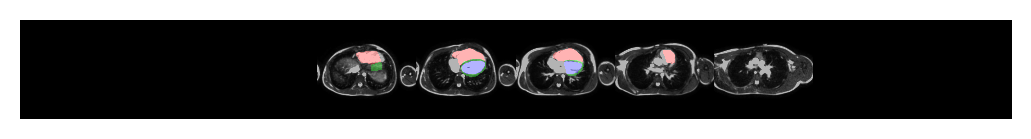

2020-12-02 08:21:06,044 INFO GT on AX


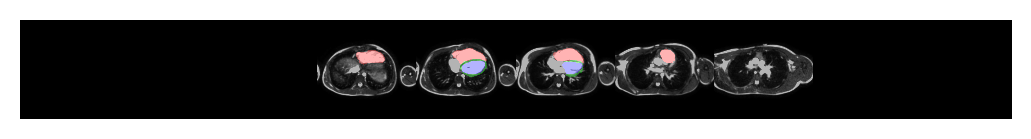

2020-12-02 08:21:06,485 INFO inv mask shape: (18, 256, 256, 4), gt mask shape: (18, 256, 256, 4)
2020-12-02 08:21:06,492 INFO DICE LV: 0.9303853511810303
2020-12-02 08:21:06,497 INFO DICE RV: 0.8888861536979675
2020-12-02 08:21:06,503 INFO DICE MYO: 0.6894634366035461
2020-12-02 08:21:06,543 INFO m: [[ 0.6016 -0.7163  0.3545 -0.9663]
 [ 0.2563  0.593   0.7637 -0.9507]
 [-0.757  -0.3684  0.54    7.523 ]]
2020-12-02 08:21:06,543 INFO m_mod: [[ 0.6016  -0.7163   0.3545  -0.1475 ]
 [ 0.2563   0.593    0.7637   0.05493]
 [-0.757   -0.3684   0.54     1.161  ]]
2020-12-02 08:21:06,544 INFO m_scaled: [[ 0.6016  -0.7163   0.3545  -0.295  ]
 [ 0.2563   0.593    0.7637   0.10986]
 [-0.757   -0.3684   0.54     2.322  ]]
2020-12-02 08:21:06,545 INFO 0000-E18NUCU2_2005-05-19_ES_msk.nrrd
2020-12-02 08:21:11,267 INFO DICE LV: 0.8831222057342529
2020-12-02 08:21:11,342 INFO DICE RV: 0.7991898059844971
2020-12-02 08:21:11,409 INFO DICE MYO: 0.7013999819755554
2020-12-02 08:21:11,880 INFO Predicted mask 

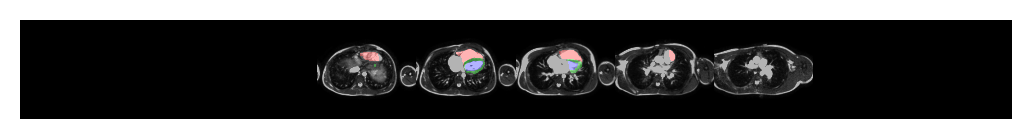

2020-12-02 08:21:12,283 INFO GT on AX


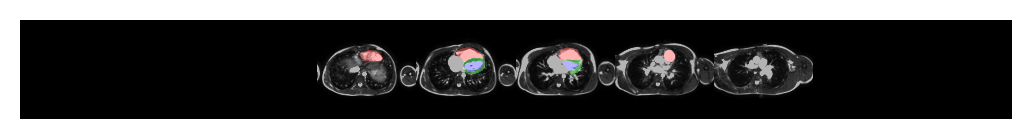

2020-12-02 08:21:12,739 INFO inv mask shape: (18, 256, 256, 4), gt mask shape: (18, 256, 256, 4)
2020-12-02 08:21:12,745 INFO DICE LV: 0.9168878197669983
2020-12-02 08:21:12,750 INFO DICE RV: 0.8027991056442261
2020-12-02 08:21:12,756 INFO DICE MYO: 0.7085965275764465
2020-12-02 08:21:12,797 INFO m: [[ 0.5967 -0.7246  0.3455 -0.9683]
 [ 0.258   0.581   0.7725 -0.9536]
 [-0.76   -0.3716  0.533   7.652 ]]
2020-12-02 08:21:12,797 INFO m_mod: [[ 0.5967  -0.7246   0.3455  -0.1494 ]
 [ 0.258    0.581    0.7725   0.05594]
 [-0.76    -0.3716   0.533    1.181  ]]
2020-12-02 08:21:12,798 INFO m_scaled: [[ 0.5967 -0.7246  0.3455 -0.2988]
 [ 0.258   0.581   0.7725  0.1119]
 [-0.76   -0.3716  0.533   2.361 ]]
2020-12-02 08:21:12,799 INFO 0000-E8030CFZ_2007-01-03_ED_msk.nrrd
2020-12-02 08:21:17,502 INFO DICE LV: 0.9137707352638245
2020-12-02 08:21:17,570 INFO DICE RV: 0.7950875163078308
2020-12-02 08:21:17,636 INFO DICE MYO: 0.6792523860931396
2020-12-02 08:21:18,115 INFO Predicted mask rotated to A

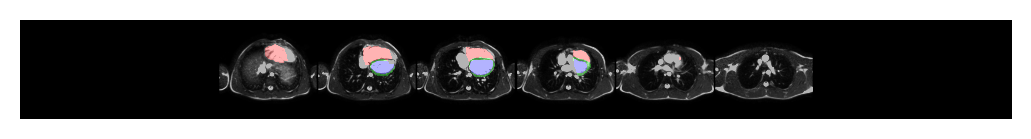

2020-12-02 08:21:18,515 INFO GT on AX


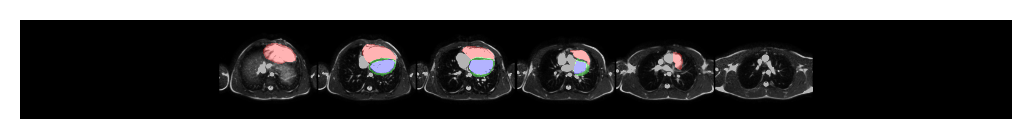

2020-12-02 08:21:18,976 INFO inv mask shape: (24, 256, 256, 4), gt mask shape: (24, 256, 256, 4)
2020-12-02 08:21:18,983 INFO DICE LV: 0.9211797714233398
2020-12-02 08:21:18,989 INFO DICE RV: 0.7985889315605164
2020-12-02 08:21:18,995 INFO DICE MYO: 0.6901156306266785
2020-12-02 08:21:19,036 INFO m: [[ 0.608  -0.7046  0.3657 -0.9634]
 [ 0.2537  0.609   0.751  -0.9473]
 [-0.7524 -0.3638  0.549   7.34  ]]
2020-12-02 08:21:19,036 INFO m_mod: [[ 0.608   -0.7046   0.3657  -0.144  ]
 [ 0.2537   0.609    0.751    0.05347]
 [-0.7524  -0.3638   0.549    1.132  ]]
2020-12-02 08:21:19,037 INFO m_scaled: [[ 0.608   -0.7046   0.3657  -0.288  ]
 [ 0.2537   0.609    0.751    0.10693]
 [-0.7524  -0.3638   0.549    2.264  ]]
2020-12-02 08:21:19,037 INFO 0000-E8030CFZ_2007-01-03_ES_msk.nrrd
2020-12-02 08:21:23,685 INFO DICE LV: 0.8652830719947815
2020-12-02 08:21:23,756 INFO DICE RV: 0.7387213706970215
2020-12-02 08:21:23,823 INFO DICE MYO: 0.7474797964096069
2020-12-02 08:21:24,306 INFO Predicted mask 

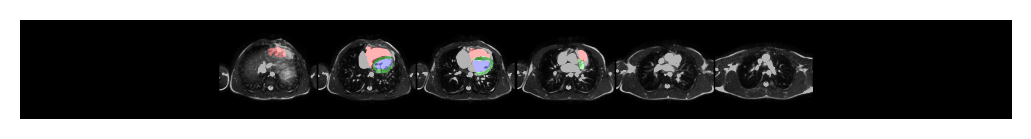

2020-12-02 08:21:24,711 INFO GT on AX


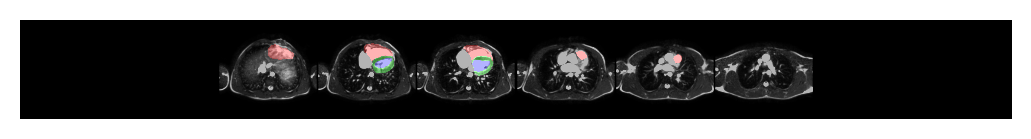

2020-12-02 08:21:25,177 INFO inv mask shape: (24, 256, 256, 4), gt mask shape: (24, 256, 256, 4)
2020-12-02 08:21:25,184 INFO DICE LV: 0.8615567088127136
2020-12-02 08:21:25,191 INFO DICE RV: 0.735991895198822
2020-12-02 08:21:25,197 INFO DICE MYO: 0.7429624795913696
2020-12-02 08:21:25,239 INFO m: [[ 0.6016 -0.717   0.3535 -0.9663]
 [ 0.2563  0.5923  0.764  -0.9507]
 [-0.757  -0.3691  0.54    7.523 ]]
2020-12-02 08:21:25,239 INFO m_mod: [[ 0.6016  -0.717    0.3535  -0.147  ]
 [ 0.2563   0.5923   0.764    0.05484]
 [-0.757   -0.3691   0.54     1.16   ]]
2020-12-02 08:21:25,240 INFO m_scaled: [[ 0.6016 -0.717   0.3535 -0.294 ]
 [ 0.2563  0.5923  0.764   0.1097]
 [-0.757  -0.3691  0.54    2.32  ]]
2020-12-02 08:21:25,241 INFO 0000-GZ4M6Z9G_2006-12-07_ED_msk.nrrd
2020-12-02 08:21:31,072 INFO DICE LV: 0.9276520013809204
2020-12-02 08:21:31,151 INFO DICE RV: 0.824371337890625
2020-12-02 08:21:31,221 INFO DICE MYO: 0.7194526791572571
2020-12-02 08:21:31,700 INFO Predicted mask rotated to AX 

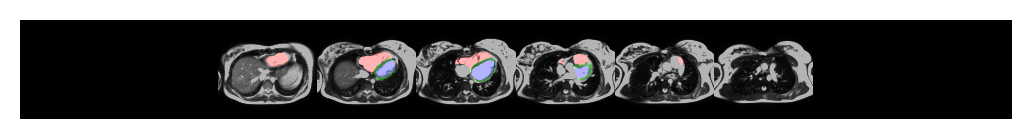

2020-12-02 08:21:32,091 INFO GT on AX


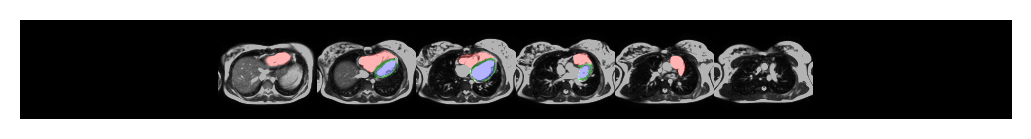

2020-12-02 08:21:32,586 INFO inv mask shape: (25, 240, 240, 4), gt mask shape: (25, 240, 240, 4)
2020-12-02 08:21:32,594 INFO DICE LV: 0.932073712348938
2020-12-02 08:21:32,601 INFO DICE RV: 0.8310014009475708
2020-12-02 08:21:32,610 INFO DICE MYO: 0.7302220463752747
2020-12-02 08:21:32,652 INFO m: [[ 0.596  -0.7256  0.3418 -0.9688]
 [ 0.2583  0.577   0.7744 -0.9536]
 [-0.76   -0.3735  0.5317  7.664 ]]
2020-12-02 08:21:32,653 INFO m_mod: [[ 0.596   -0.7256   0.3418  -0.1494 ]
 [ 0.2583   0.577    0.7744   0.05576]
 [-0.76    -0.3735   0.5317   1.181  ]]
2020-12-02 08:21:32,653 INFO m_scaled: [[ 0.596  -0.7256  0.3418 -0.2988]
 [ 0.2583  0.577   0.7744  0.1115]
 [-0.76   -0.3735  0.5317  2.361 ]]
2020-12-02 08:21:32,654 INFO 0000-GZ4M6Z9G_2006-12-07_ES_msk.nrrd
2020-12-02 08:21:37,349 INFO DICE LV: 0.8599594831466675
2020-12-02 08:21:37,422 INFO DICE RV: 0.6534239649772644
2020-12-02 08:21:37,487 INFO DICE MYO: 0.7391522526741028
2020-12-02 08:21:37,972 INFO Predicted mask rotated to AX

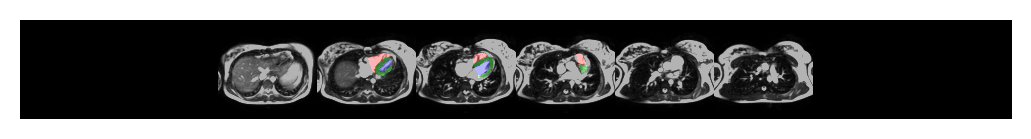

2020-12-02 08:21:38,365 INFO GT on AX


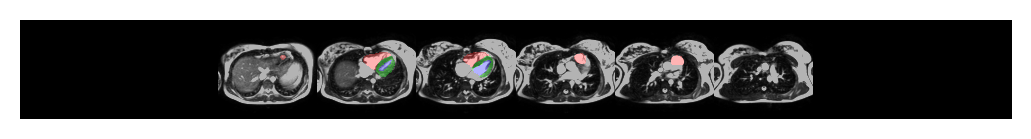

2020-12-02 08:21:38,827 INFO inv mask shape: (25, 240, 240, 4), gt mask shape: (25, 240, 240, 4)
2020-12-02 08:21:38,835 INFO DICE LV: 0.8708720803260803
2020-12-02 08:21:38,842 INFO DICE RV: 0.6535673141479492
2020-12-02 08:21:38,849 INFO DICE MYO: 0.7475417852401733
2020-12-02 08:21:38,889 INFO m: [[ 0.5957 -0.7275  0.341  -0.9688]
 [ 0.2585  0.5757  0.776  -0.954 ]
 [-0.7607 -0.3743  0.531   7.68  ]]
2020-12-02 08:21:38,890 INFO m_mod: [[ 0.5957 -0.7275  0.341  -0.1494]
 [ 0.2585  0.5757  0.776   0.0559]
 [-0.7607 -0.3743  0.531   1.184 ]]
2020-12-02 08:21:38,890 INFO m_scaled: [[ 0.5957 -0.7275  0.341  -0.2988]
 [ 0.2585  0.5757  0.776   0.1118]
 [-0.7607 -0.3743  0.531   2.367 ]]
2020-12-02 08:21:38,891 INFO 0000-HNE7CVMU_2006-10-27_ED_msk.nrrd
2020-12-02 08:21:43,656 INFO DICE LV: 0.8779809474945068
2020-12-02 08:21:43,724 INFO DICE RV: 0.7477686405181885
2020-12-02 08:21:43,790 INFO DICE MYO: 0.652833104133606
2020-12-02 08:21:44,268 INFO Predicted mask rotated to AX on original

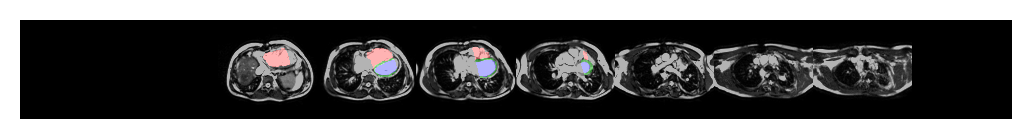

2020-12-02 08:21:44,662 INFO GT on AX


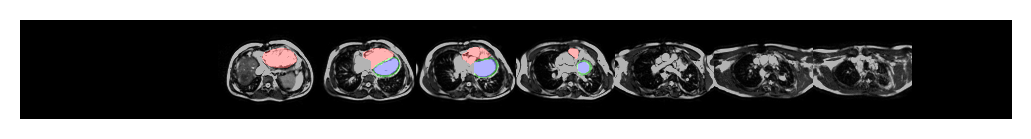

2020-12-02 08:21:45,134 INFO inv mask shape: (27, 256, 256, 4), gt mask shape: (27, 256, 256, 4)
2020-12-02 08:21:45,142 INFO DICE LV: 0.8806730508804321
2020-12-02 08:21:45,151 INFO DICE RV: 0.7597942352294922
2020-12-02 08:21:45,158 INFO DICE MYO: 0.6584054231643677
2020-12-02 08:21:45,199 INFO m: [[ 0.598  -0.722   0.3474 -0.968 ]
 [ 0.2576  0.584   0.77   -0.9526]
 [-0.759  -0.371   0.535   7.6   ]]
2020-12-02 08:21:45,199 INFO m_mod: [[ 0.598   -0.722    0.3474  -0.1484 ]
 [ 0.2576   0.584    0.77     0.05554]
 [-0.759   -0.371    0.535    1.171  ]]
2020-12-02 08:21:45,200 INFO m_scaled: [[ 0.598  -0.722   0.3474 -0.2969]
 [ 0.2576  0.584   0.77    0.1111]
 [-0.759  -0.371   0.535   2.342 ]]
2020-12-02 08:21:45,200 INFO 0000-HNE7CVMU_2006-10-27_ES_msk.nrrd
2020-12-02 08:21:49,931 INFO DICE LV: 0.8476587533950806
2020-12-02 08:21:49,997 INFO DICE RV: 0.6508971452713013
2020-12-02 08:21:50,062 INFO DICE MYO: 0.7773797512054443
2020-12-02 08:21:50,541 INFO Predicted mask rotated to A

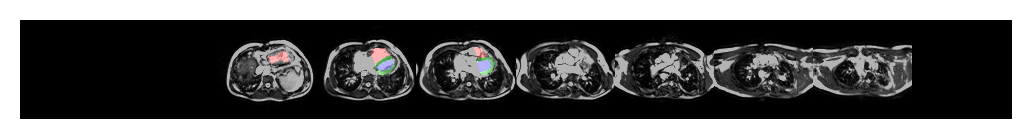

2020-12-02 08:21:50,945 INFO GT on AX


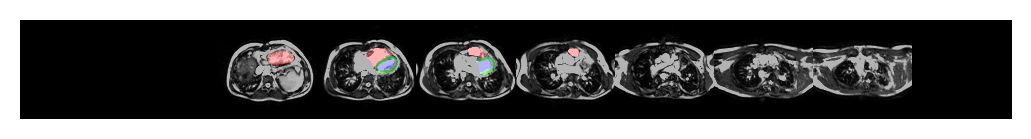

2020-12-02 08:21:51,411 INFO inv mask shape: (27, 256, 256, 4), gt mask shape: (27, 256, 256, 4)
2020-12-02 08:21:51,420 INFO DICE LV: 0.8447657227516174
2020-12-02 08:21:51,428 INFO DICE RV: 0.6602147817611694
2020-12-02 08:21:51,436 INFO DICE MYO: 0.7821946740150452
2020-12-02 08:21:51,476 INFO m: [[ 0.593  -0.732   0.3357 -0.97  ]
 [ 0.2593  0.568   0.781  -0.9556]
 [-0.7627 -0.3757  0.527   7.766 ]]
2020-12-02 08:21:51,476 INFO m_mod: [[ 0.593   -0.732    0.3357  -0.1514 ]
 [ 0.2593   0.568    0.781    0.05682]
 [-0.7627  -0.3757   0.527    1.196  ]]
2020-12-02 08:21:51,477 INFO m_scaled: [[ 0.593   -0.732    0.3357  -0.3027 ]
 [ 0.2593   0.568    0.781    0.11365]
 [-0.7627  -0.3757   0.527    2.393  ]]
2020-12-02 08:21:51,478 INFO 0000-KK9VRLND_2006-07-10_ED_msk.nrrd
2020-12-02 08:21:56,277 INFO DICE LV: 0.8455572128295898
2020-12-02 08:21:56,345 INFO DICE RV: 0.8185593485832214
2020-12-02 08:21:56,412 INFO DICE MYO: 0.6488344073295593
2020-12-02 08:21:56,920 INFO Predicted mask 

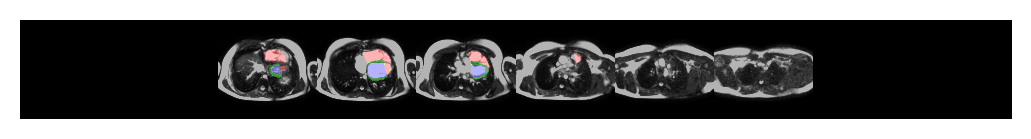

2020-12-02 08:21:57,309 INFO GT on AX


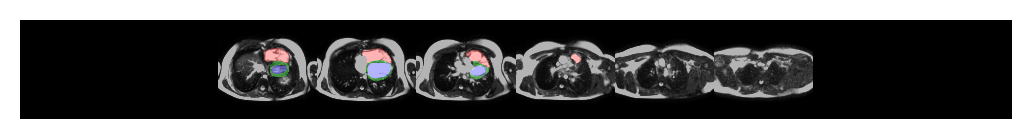

2020-12-02 08:21:57,773 INFO inv mask shape: (26, 256, 256, 4), gt mask shape: (26, 256, 256, 4)
2020-12-02 08:21:57,782 INFO DICE LV: 0.836982011795044
2020-12-02 08:21:57,790 INFO DICE RV: 0.8159972429275513
2020-12-02 08:21:57,799 INFO DICE MYO: 0.644974946975708
2020-12-02 08:21:57,843 INFO m: [[ 0.6123 -0.6973  0.3718 -0.962 ]
 [ 0.2524  0.6187  0.7437 -0.945 ]
 [-0.749  -0.3618  0.555   7.227 ]]
2020-12-02 08:21:57,844 INFO m_mod: [[ 0.6123  -0.6973   0.3718  -0.1416 ]
 [ 0.2524   0.6187   0.7437   0.05246]
 [-0.749   -0.3618   0.555    1.114  ]]
2020-12-02 08:21:57,844 INFO m_scaled: [[ 0.6123 -0.6973  0.3718 -0.2832]
 [ 0.2524  0.6187  0.7437  0.1049]
 [-0.749  -0.3618  0.555   2.229 ]]
2020-12-02 08:21:57,845 INFO 0000-KK9VRLND_2006-07-10_ES_msk.nrrd
2020-12-02 08:22:02,620 INFO DICE LV: 0.690389096736908
2020-12-02 08:22:02,690 INFO DICE RV: 0.6355507373809814
2020-12-02 08:22:02,760 INFO DICE MYO: 0.623466968536377
2020-12-02 08:22:03,231 INFO Predicted mask rotated to AX on

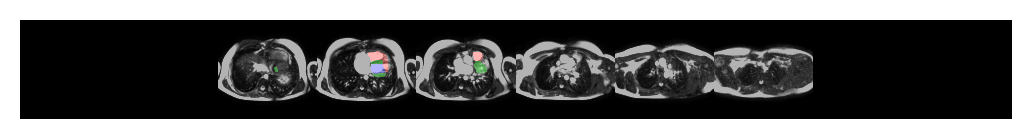

2020-12-02 08:22:03,623 INFO GT on AX


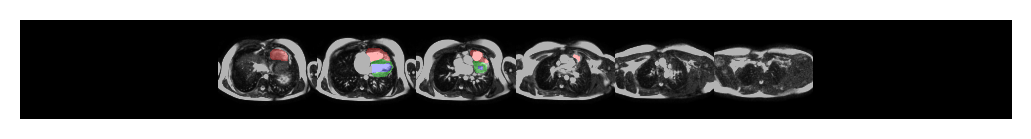

2020-12-02 08:22:04,092 INFO inv mask shape: (26, 256, 256, 4), gt mask shape: (26, 256, 256, 4)
2020-12-02 08:22:04,100 INFO DICE LV: 0.6957521438598633
2020-12-02 08:22:04,108 INFO DICE RV: 0.6147274374961853
2020-12-02 08:22:04,116 INFO DICE MYO: 0.631449818611145
2020-12-02 08:22:04,158 INFO m: [[ 0.6094 -0.7017  0.368  -0.963 ]
 [ 0.2532  0.6123  0.7485 -0.9463]
 [-0.751  -0.3633  0.5513  7.29  ]]
2020-12-02 08:22:04,159 INFO m_mod: [[ 0.6094 -0.7017  0.368  -0.1426]
 [ 0.2532  0.6123  0.7485  0.053 ]
 [-0.751  -0.3633  0.5513  1.124 ]]
2020-12-02 08:22:04,159 INFO m_scaled: [[ 0.6094 -0.7017  0.368  -0.2852]
 [ 0.2532  0.6123  0.7485  0.106 ]
 [-0.751  -0.3633  0.5513  2.248 ]]
2020-12-02 08:22:04,160 INFO 0000-TET48V2Z_2008-01-10_ED_msk.nrrd
2020-12-02 08:22:09,941 INFO DICE LV: 0.9174623489379883
2020-12-02 08:22:10,018 INFO DICE RV: 0.8699252009391785
2020-12-02 08:22:10,092 INFO DICE MYO: 0.6934405565261841
2020-12-02 08:22:10,574 INFO Predicted mask rotated to AX on original

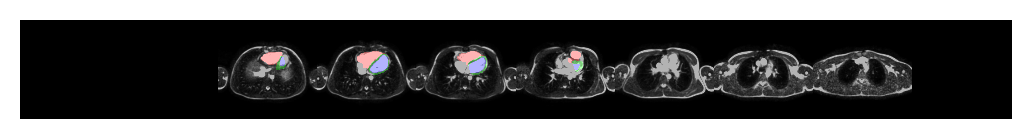

2020-12-02 08:22:10,977 INFO GT on AX


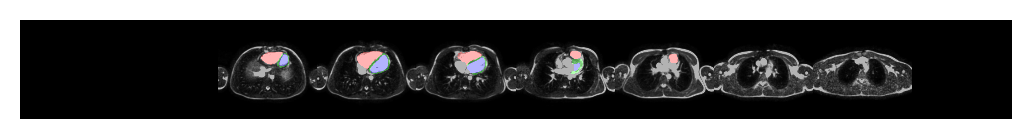

2020-12-02 08:22:11,448 INFO inv mask shape: (23, 256, 256, 4), gt mask shape: (23, 256, 256, 4)
2020-12-02 08:22:11,456 INFO DICE LV: 0.9192123413085938
2020-12-02 08:22:11,463 INFO DICE RV: 0.8724533915519714
2020-12-02 08:22:11,470 INFO DICE MYO: 0.7044290900230408
2020-12-02 08:22:11,520 INFO m: [[ 0.5996 -0.719   0.35   -0.967 ]
 [ 0.2568  0.588   0.7666 -0.9517]
 [-0.758  -0.3699  0.5376  7.56  ]]
2020-12-02 08:22:11,521 INFO m_mod: [[ 0.5996 -0.719   0.35   -0.148 ]
 [ 0.2568  0.588   0.7666  0.0551]
 [-0.758  -0.3699  0.5376  1.166 ]]
2020-12-02 08:22:11,521 INFO m_scaled: [[ 0.5996 -0.719   0.35   -0.296 ]
 [ 0.2568  0.588   0.7666  0.1102]
 [-0.758  -0.3699  0.5376  2.332 ]]
2020-12-02 08:22:11,522 INFO 0000-TET48V2Z_2008-01-10_ES_msk.nrrd
2020-12-02 08:22:16,246 INFO DICE LV: 0.8474341630935669
2020-12-02 08:22:16,321 INFO DICE RV: 0.792384922504425
2020-12-02 08:22:16,394 INFO DICE MYO: 0.6980940699577332
2020-12-02 08:22:16,866 INFO Predicted mask rotated to AX on original

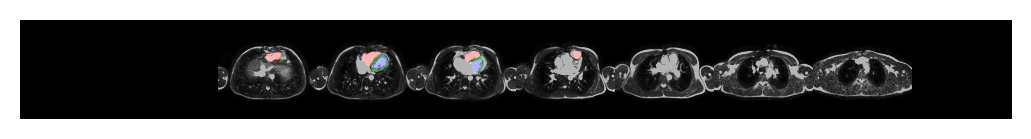

2020-12-02 08:22:17,264 INFO GT on AX


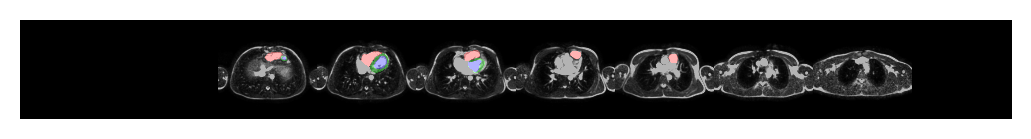

2020-12-02 08:22:17,727 INFO inv mask shape: (23, 256, 256, 4), gt mask shape: (23, 256, 256, 4)
2020-12-02 08:22:17,734 INFO DICE LV: 0.8482820987701416
2020-12-02 08:22:17,741 INFO DICE RV: 0.7958053350448608
2020-12-02 08:22:17,749 INFO DICE MYO: 0.7139922380447388
2020-12-02 08:22:17,790 INFO m: [[ 0.6    -0.718   0.3516 -0.967 ]
 [ 0.2563  0.5894  0.7656 -0.951 ]
 [-0.7573 -0.3694  0.538   7.547 ]]
2020-12-02 08:22:17,791 INFO m_mod: [[ 0.6     -0.718    0.3516  -0.1475 ]
 [ 0.2563   0.5894   0.7656   0.05505]
 [-0.7573  -0.3694   0.538    1.164  ]]
2020-12-02 08:22:17,792 INFO m_scaled: [[ 0.6    -0.718   0.3516 -0.295 ]
 [ 0.2563  0.5894  0.7656  0.1101]
 [-0.7573 -0.3694  0.538   2.328 ]]
2020-12-02 08:22:17,793 INFO 0000-Z0QR21CJ_2005-11-02_ED_msk.nrrd
2020-12-02 08:22:23,553 INFO DICE LV: 0.8888227939605713
2020-12-02 08:22:23,635 INFO DICE RV: 0.8127191066741943
2020-12-02 08:22:23,714 INFO DICE MYO: 0.609685480594635
2020-12-02 08:22:24,225 INFO Predicted mask rotated to AX

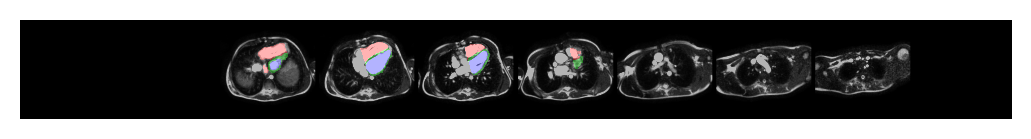

2020-12-02 08:22:24,639 INFO GT on AX


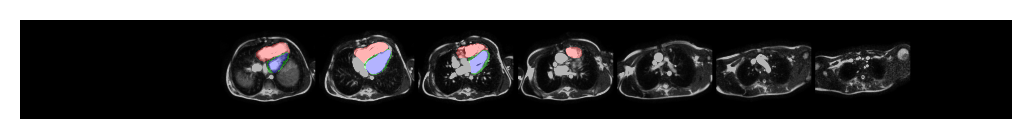

2020-12-02 08:22:25,147 INFO inv mask shape: (26, 256, 256, 4), gt mask shape: (26, 256, 256, 4)
2020-12-02 08:22:25,155 INFO DICE LV: 0.895007848739624
2020-12-02 08:22:25,162 INFO DICE RV: 0.8001036643981934
2020-12-02 08:22:25,170 INFO DICE MYO: 0.6388659477233887
2020-12-02 08:22:25,218 INFO m: [[ 0.5977 -0.723   0.3462 -0.968 ]
 [ 0.2573  0.5825  0.771  -0.953 ]
 [-0.7593 -0.3718  0.534   7.62  ]]
2020-12-02 08:22:25,218 INFO m_mod: [[ 0.5977  -0.723    0.3462  -0.1489 ]
 [ 0.2573   0.5825   0.771    0.05563]
 [-0.7593  -0.3718   0.534    1.175  ]]
2020-12-02 08:22:25,219 INFO m_scaled: [[ 0.5977  -0.723    0.3462  -0.2979 ]
 [ 0.2573   0.5825   0.771    0.11127]
 [-0.7593  -0.3718   0.534    2.35   ]]
2020-12-02 08:22:25,220 INFO 0000-Z0QR21CJ_2005-11-02_ES_msk.nrrd
2020-12-02 08:22:29,962 INFO DICE LV: 0.8502032160758972
2020-12-02 08:22:30,052 INFO DICE RV: 0.6684922575950623
2020-12-02 08:22:30,134 INFO DICE MYO: 0.617763340473175
2020-12-02 08:22:30,645 INFO Predicted mask ro

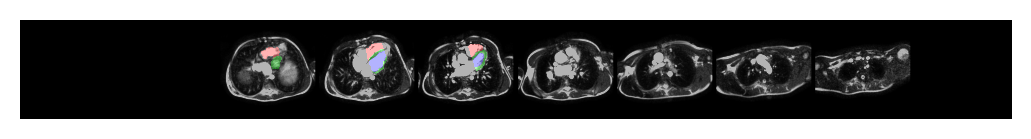

2020-12-02 08:22:31,061 INFO GT on AX


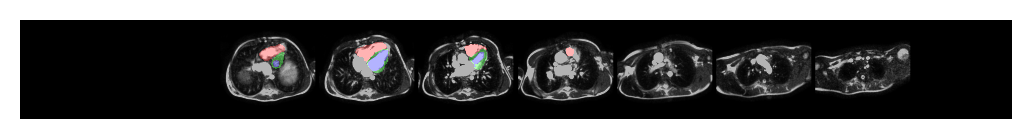

2020-12-02 08:22:31,556 INFO inv mask shape: (26, 256, 256, 4), gt mask shape: (26, 256, 256, 4)
2020-12-02 08:22:31,565 INFO DICE LV: 0.861023485660553
2020-12-02 08:22:31,573 INFO DICE RV: 0.6758041977882385
2020-12-02 08:22:31,581 INFO DICE MYO: 0.6442832350730896
2020-12-02 08:22:31,635 INFO m: [[ 0.607  -0.7065  0.3643 -0.964 ]
 [ 0.2542  0.607   0.7534 -0.9478]
 [-0.753  -0.3647  0.548   7.367 ]]
2020-12-02 08:22:31,636 INFO m_mod: [[ 0.607   -0.7065   0.3643  -0.144  ]
 [ 0.2542   0.607    0.7534   0.05383]
 [-0.753   -0.3647   0.548    1.136  ]]
2020-12-02 08:22:31,636 INFO m_scaled: [[ 0.607   -0.7065   0.3643  -0.288  ]
 [ 0.2542   0.607    0.7534   0.10767]
 [-0.753   -0.3647   0.548    2.271  ]]


In [40]:
# predict on all test images, once with postprocessing, and once without
use_modified_translation = FOCUS_LOSS # True, if we use the unet extension to learn a second set of translation parameters
combine = False
dual_model = False
experiment_identifier = 'tests_72_112_112_sp3_1ax_1sax_1focus_thres08_inpl_f0_2nd_unet_round_crop'

logging.info('use modified translation to scale: {}'.format(use_modified_translation))
path_1 = 'data/predicted/{}/3D/'.format(experiment_identifier)
path_2 = path_1.replace('_post', '_NoPost')

# make predictions with different parameters in the same flow
for i in range(ax_full.shape[0]):
    select_image_in_batch_(im=i,slice_n=5, debug=False,export_path=path_1, save=True, postprocess=True, use_mod_translation=use_modified_translation, combine=combine, dual_model=dual_model)
    #select_image_in_batch_(im=i,slice_n=5, debug=False,export_path=path_1, save=True, postprocess=False, use_mod_translation=use_modified_translation, combine=combine, dual_model=dual_model)

In [ ]:
# Initial version, please check before execute
assert(False==True)
@interact
def select_image_in_batch(im=(0, x_.shape[0] - 1, 1), 
                          slice_n=(1, 6), 
                          export_path='data/predicted/temp/',
                          shift_z=20,
                          debug=False,
                         save=False):
    """
    Use the spatial transformer to rotate, predict segmentations, reverse the rotation on the masks and save the nrrd files (image, gt and pred)
    :param im: slider to select another image from the generator
    :param slice_n: The show_2D_3D method slices to a maximum of 20 slices in z, this parameter allows to further slice the visualisations
    :param export_path: path to save the img, gt and prediction volumes as nrrd file, the file names will be the same as in x_ax_val...
    :param debug: bool to enable plotting of the intermediate steps
    :return: void
    """
    global m

    full_file_name = y_val_ax[im]
    filename = os.path.basename(full_file_name)
    logging.info(filename)
    temp = x_[im]
    temp_ = y_[im]
    ax_full_ = ax_full[im]
    ax_msk_full_gt = ax_msk_[im]
    
    # define a different logging level to make the generator steps visible
    logging.getLogger().setLevel(logging.INFO)
    logging.info('Prediction on AX volume:')
    if debug: show_2D_or_3D(temp[::slice_n])
    plt.show()
    
    # Predict rotation of AX and get transformation matrix
    logging.info('AX --> SAX rotated by the model')
    pred, m, mask_pred= model.predict(np.expand_dims(temp, axis=0))
    if debug: show_2D_or_3D(pred[0][::slice_n])
    plt.show()
    
    # make copy of m for reusage
    #m_ = m.copy()
    m = np.reshape(m, (3,4))
    # scale translation part of the affine matrix from spacing 5 to 1.5
    m_t = m[:,3]
    m_t = (m_t *5)/1.5
    m[:,3] = m_t
    m_ = m.flatten()
    
    # show the target AXtoSAX volume
    logging.getLogger().setLevel(logging.INFO)
    logging.info('Target (SAX):')
    if debug: show_2D_or_3D(temp_[::slice_n])
    plt.show()
    
    # Repeat the transformation on ax with full resolution
    logging.info('Repeat the transformation on the full resolution')
    logging.getLogger().setLevel(logging.ERROR)
    transformer = create_affine_transformer_fixed(config=msk_cfg, interp_method='linear')
    pred, m_ = transformer.predict(x=[np.expand_dims(ax_full_, axis=0), np.expand_dims(m_,axis=0)])
    if debug: show_2D_or_3D(pred[0][::slice_n*3])
    plt.show()
    
    # reshape m to matrix
    m = np.reshape(m, (3, 4))

    # create a square ident matrix slice m into it
    m_matrix = np.identity(4)
    # slice m (3,4) into identity (4,4)
    m_matrix[:3, :] = m
    # calc inverse, flatten the matrix and cut off the last row for the spatial transformer
    m_matrix_inverse = np.linalg.inv(m_matrix)
    m_matrix_inverse_flatten = m_matrix_inverse.flatten()[:-4]

    # apply the inverse to our AXtoSAX volume
    logging.getLogger().setLevel(logging.INFO)
    logging.info('Apply the invers rotation to our AXtoSAX')
    logging.getLogger().setLevel(logging.ERROR)
    inv, _ = transformer.predict(x=[pred, np.expand_dims(m_matrix_inverse_flatten, axis=0)])
    if debug: show_2D_or_3D(inv[0][::slice_n*3])
    plt.show()

    # load a 3D wrapper model for segmenting the new SAX
    if 'unet' in globals():
        msk = unet.predict(x=pred)
        msk = clean_3d_prediction_3d_cc(from_channel_to_flat(msk[0] >= 0.5))
        msk = transform_to_binary_mask(msk)
        logging.getLogger().setLevel(logging.INFO)
        logging.info('Predicted mask')
        if debug: show_2D_or_3D(pred[0][::slice_n*3], msk[::slice_n*3])
        plt.show()

        # apply inverse to our msk and plot it together with the inverse AXtoSAX
        logging.getLogger().setLevel(logging.ERROR)
        m_transformer = create_affine_transformer_fixed(config=msk_cfg, interp_method='nearest')
        inv_msk = list()
        for c in range(msk.shape[-1]):
            inv_m, _ = m_transformer.predict(
                x=[np.expand_dims(msk[..., c], axis=0), np.expand_dims(m_matrix_inverse_flatten, axis=0)])
            inv_msk.append(inv_m[..., 0] >= 0.5)
        inv_msk = np.stack(inv_msk, axis=-1)
        
        # postprocessing
        logging.getLogger().setLevel(logging.INFO)
        logging.info('Predicted mask rotated to AX on original AX image - before postprocessing')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[0][::slice_n*3])
        plt.show()
        
        inv_msk = from_channel_to_flat(inv_msk[0])
        kernel = np.ones((5,5),np.uint8)
        kernel_small = np.ones((3,3),np.uint8)
        
        inv_msk = clean_3d_prediction_3d_cc(inv_msk)
        logging.info('Predicted mask rotated to AX on original AX image - after connected component filtering')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3])
        plt.show()
        
        inv_msk = np.stack([cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel_small) for img in inv_msk],axis=0)
        logging.info('Predicted mask rotated to AX on original AX image - after closing')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3])
        plt.show()
        
        inv_msk = np.stack([cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=2) for img in inv_msk],axis=0)
        logging.info('Predicted mask rotated to AX on original AX image - after opening')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3])
        plt.show()
        
        inv_msk = np.stack([cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel) for img in inv_msk],axis=0)
        logging.info('Predicted mask rotated to AX on original AX image - after closing')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3])
        plt.show()
        
        inv_msk = clean_3d_prediction_3d_cc(inv_msk)
        logging.info('Predicted mask rotated to AX on original AX image - after connected component filtering')
        if debug: show_2D_or_3D(ax_full_, inv_msk)
        plt.show()

        logging.getLogger().setLevel(logging.INFO)
        logging.info('Predicted mask rotated to AX on inverse AXtoSAX')
        if debug: show_2D_or_3D(inv[0][::slice_n*3], inv_msk[::slice_n*3])
        plt.show()
        logging.info('Predicted mask rotated to AX on original AX image')
        show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3])
        plt.show()
        
        # get the AX target segmentation, processed by the generator to have it in the same shape
        #msk_flatten = clean_3d_prediction_3d_cc(from_channel_to_flat(inv_msk[0]))
        msk_gt_flatten = from_channel_to_flat(ax_msk_full_gt)
        logging.info('GT on AX')
        show_2D_or_3D(ax_full_[::slice_n*3], msk_gt_flatten[::slice_n*3])
        plt.show()
        
        # create a nrrd file for the gt, pred and image volume
        sitk_pred = sitk.GetImageFromArray(inv_msk)
        sitk_ax_img = sitk.GetImageFromArray(ax_full_)
        sitk_ax_msk = sitk.GetImageFromArray(msk_gt_flatten)

        ensure_dir(os.path.join(export_path, 'pred'))
        ensure_dir(os.path.join(export_path, 'image'))
        ensure_dir(os.path.join(export_path, 'gt'))
        
        # load a reference nrrd file, copy all metadata and save the volumes
        reference_sitk = sitk.ReadImage(full_file_name)
        if save:
            copy_meta_and_save(sitk_pred, reference_sitk, os.path.join(export_path, 'pred', filename))
            copy_meta_and_save(sitk_ax_img, reference_sitk,os.path.join(export_path, 'image', filename.replace('msk', 'img')))
            copy_meta_and_save(sitk_ax_msk, reference_sitk, os.path.join(export_path, 'gt', filename))
        # shutil.copyfile(full_file_name, os.path.join(export_path, 'gt', filename))
    else:
        logging.info('no unet in global namespace, segmentation is not possible')

    logging.info('MSE: {}'.format(mse(pred[0], ax_full_).numpy().mean()))
    #logging.info('MSE center cube: {}'.format(metr.cubic_center_loss_wrapper(pred[0], temp_).numpy().mean()))
    try:
        print(np.reshape(m[0], (3, 4)))
    except Exception as e:
        pass


# Further tests, where do our model fail, do we over- or under-segment

In [20]:
gt.shape

(144, 224, 224, 3)

In [21]:
zero = np.zeros_like(gt[...,0:1])
temp = np.concatenate((zero,gt),axis=-1)
temp.shape

(144, 224, 224, 4)

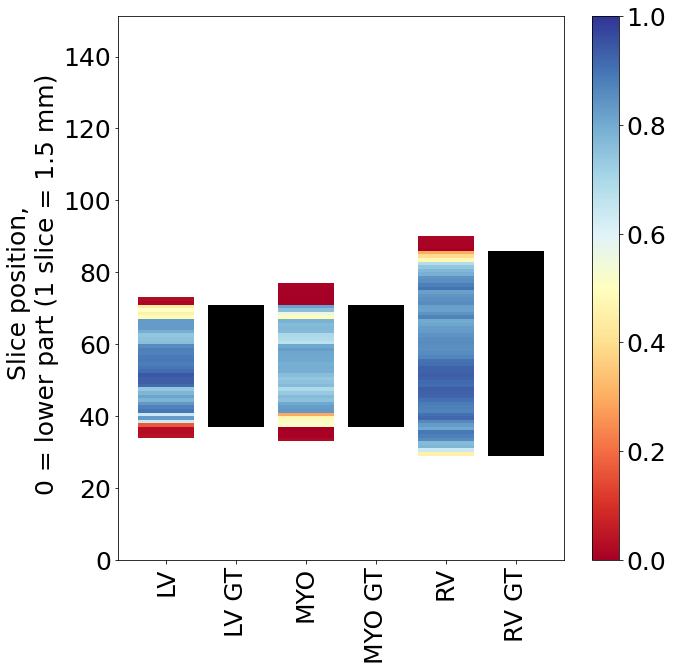

In [22]:
from src.visualization.Visualize import plot_dice_per_slice_bar, plot_dice_per_slice_line
plot_dice_per_slice_bar(gt,pred)

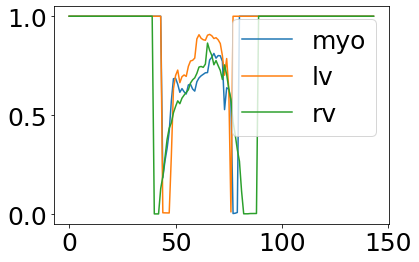

In [31]:
# Create a lineplot for the errors within the volume
plot_dice_per_slice_line(gt,pred)

# Temp tests

In [ ]:
cmap(1)

In [ ]:
# check the memory usage
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)
